In [1]:
%reload_ext autoreload
%autoreload
import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import toml
import os
import re
import json

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("colorblind"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from wordcloud import WordCloud
from IPython.display import JSON
from collections import Counter
from tqdm import tqdm
from pathlib import Path

from sapsam import parser, constants, detector, filters, SGXConverter
from sapsam.filters import DataFilter
from sapsam.SignavioBestPracticesChecker import best_practices_checker

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [3]:
# mappings for namespaces and element types
with open(constants.SRC_ROOT / 'mappings.json') as json_file:
    mappings = json.load(json_file)

In [4]:
SGXConverter.convert_sgx_to_csv()

Found 0 SGX files.
Found 1 CSV files. Proceeding with analysis...


# Read Data

Let's first read in the meta data of all models in the dataset.

In [5]:
df_meta = parser.parse_model_metadata()
df_meta.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.78it/s]


revision_id  organisation_id  \
model_id                                                         
c80cf953d4544c408b1d4613c0eaa604          NaN              NaN   

                                               datetime  description  \
model_id                                                               
c80cf953d4544c408b1d4613c0eaa604  2023-12-13 12:31:19.0          NaN   

                                                                           name  \
model_id                                                                          
c80cf953d4544c408b1d4613c0eaa604  MHR-10-20-10 Create/Update Foundation Element   

                                 type                            namespace  
model_id                                                                    
c80cf953d4544c408b1d4613c0eaa604  NaN  http://b3mn.org/stencilset/bpmn2.0#

# Convention checking

In [38]:
p = parser.BpmnModelParser()
model_json = p.parse_model_elements('1')
model_json.set_index('Model ID', inplace=True)
model_json = model_json['Model JSON'].iloc[0]
name = df_bpmn['name'].iloc[0]
#print(name)
model_id = df_bpmn.index.get_level_values(0)[0]
#print(model_id)
guideline_id = '4551c2229baa4c79a151b5a0cc1010d2'
#print(model_json)

result = best_practices_checker(name, model_id, guideline_id, model_json)
result

{'errors': 0, 'warnings': 13, 'info': 38}

# Filtering example processes

The dataset includes the following vendor provided example processes.

In [6]:
import json
with open(constants.SRC_ROOT / "prefilled_example_processes.json") as data_file:    
    examples = json.load(data_file)

Here is the list of all example processes names:

In [7]:
example_names = []
for batch in examples["example_processes"]:
    example_names.extend(batch["content"])
example_names = set(example_names)
example_names

{'Arbeitsmittel beschaffen',
 'BANF-zu-Bestellung',
 'Bestellung-zu-Lieferung',
 'Bewerber prüfen',
 'Bewerbungseingang',
 'Check quantity and quality',
 'Commande de pièces',
 'Contrôler la quantité et la qualité',
 'Delivery-to-Payment',
 "Donner l'équipement de travail",
 'Ebene  2 - Prozessbereich: Personalwesen',
 'Ebene 1 - Prozesslandkarte ACME AG',
 'Ebene 2 - Prozessbereich: Auftragsdurchführung',
 'Ebene 2 - Prozessbereich: Produktentwicklung',
 'Employee Onboarding',
 "Installation d'un employé",
 'Level  2 - Process Area: Human Resources',
 'Level 1 - Value Chain ACME AG',
 'Level 2 - Process Area: Order Processing',
 'Level 2 - Process Area: Product Development',
 'Lieferung-zu-Bezahlung',
 'Menge und Qualität überprüfen',
 'Mitarbeiter Onboarding',
 "Niveau 1 – Chaine de valeur d'ACME AG",
 'Niveau 2 - Processus de développement produit',
 'Niveau 2 - Processus de gestion des commandes',
 'Niveau 2 - Processus des Ressources Humaines',
 'Procure parts',
 'Procurement of W

Now let's take a look at the number of examples processes in the dataset (note that we decide this based on the process name which is more of a rough estimate rather than an accurate number):

In [8]:
df_meta_examples = df_meta[df_meta["name"].isin(example_names)]
len(df_meta_examples)

0

This is the percentage of example process from the dataset:

In [9]:
len(df_meta_examples)/len(df_meta)

0.0

This is the number of models in the dataset without example processes (again, based on process names):

In [10]:
len(df_meta)-len(df_meta_examples)

1

And the percentage of models in the dataset without example processes:

In [11]:
(len(df_meta)-len(df_meta_examples))/len(df_meta)

1.0

We apply the filter to perform the analysis on the dataset without examples processes:

In [12]:
df_meta = DataFilter(df_meta)
df_meta = df_meta.filter_data("example_processes")
len(df_meta)

1

We see that the size of the dataset now matches the previous calculation of the number of models without example processes.

# Modeling notations

We want to examine the usage of modeling notations in the dataset.

Let's start with counting the number of models in different modeling notations.

In [13]:
df_notations = pd.DataFrame.from_dict(dict(Counter(df_meta["namespace"])),orient = "index")
df_notations.reset_index(inplace=True)
df_notations.columns = ["Notation","Frequency"]
df_notations.sort_values(by=['Frequency'], ascending=False, inplace=True, ignore_index=True)

We map the namespaces to the common names for the modeling notations.

In [14]:
d_namespaces = mappings["namespaces"]
d_namespaces_reverse = {}
for k,v in d_namespaces.items():
    d_namespaces_reverse[v]=k
#df_notations = df_notations.replace({'Notation' : d_namespaces})

In [15]:
def map_namespaces(namespace):
    return d_namespaces.get(namespace, 'Unknown')
df_notations['Notation'] = df_notations['Notation'].map(lambda x: map_namespaces(x))
df_notations

Notation  Frequency
0  BPMN 2.0          1

Now, we have the option to filter the data for the analysis.

In this case, the filter takes between **1** and **3** arguments, where "namespaces" is the filter type.

The **2nd** argument can be an integer, a notation name, or "max". It indicates the number of individual notations that should be kept in the filtered dataset, by descending frequency. The actual notation name can be used, if all others notations should be removed from the dataset.

The **3rd** argument is optional and represents a frequency threshold, under which the corresponding notations will be aggregated into a subgroup "Other".

For example, let's aggregate modeling notations which are used for less than 100 models in "Other".

In [16]:
if df_notations['Notation'].nunique() > 3:
    df_notations = DataFilter(df_notations)
    df_notations = df_notations.filter_data("namespaces", "max", 5)
df_notations

Notation  Frequency
0  BPMN 2.0          1

We can visualise the number of models in different modeling notations.

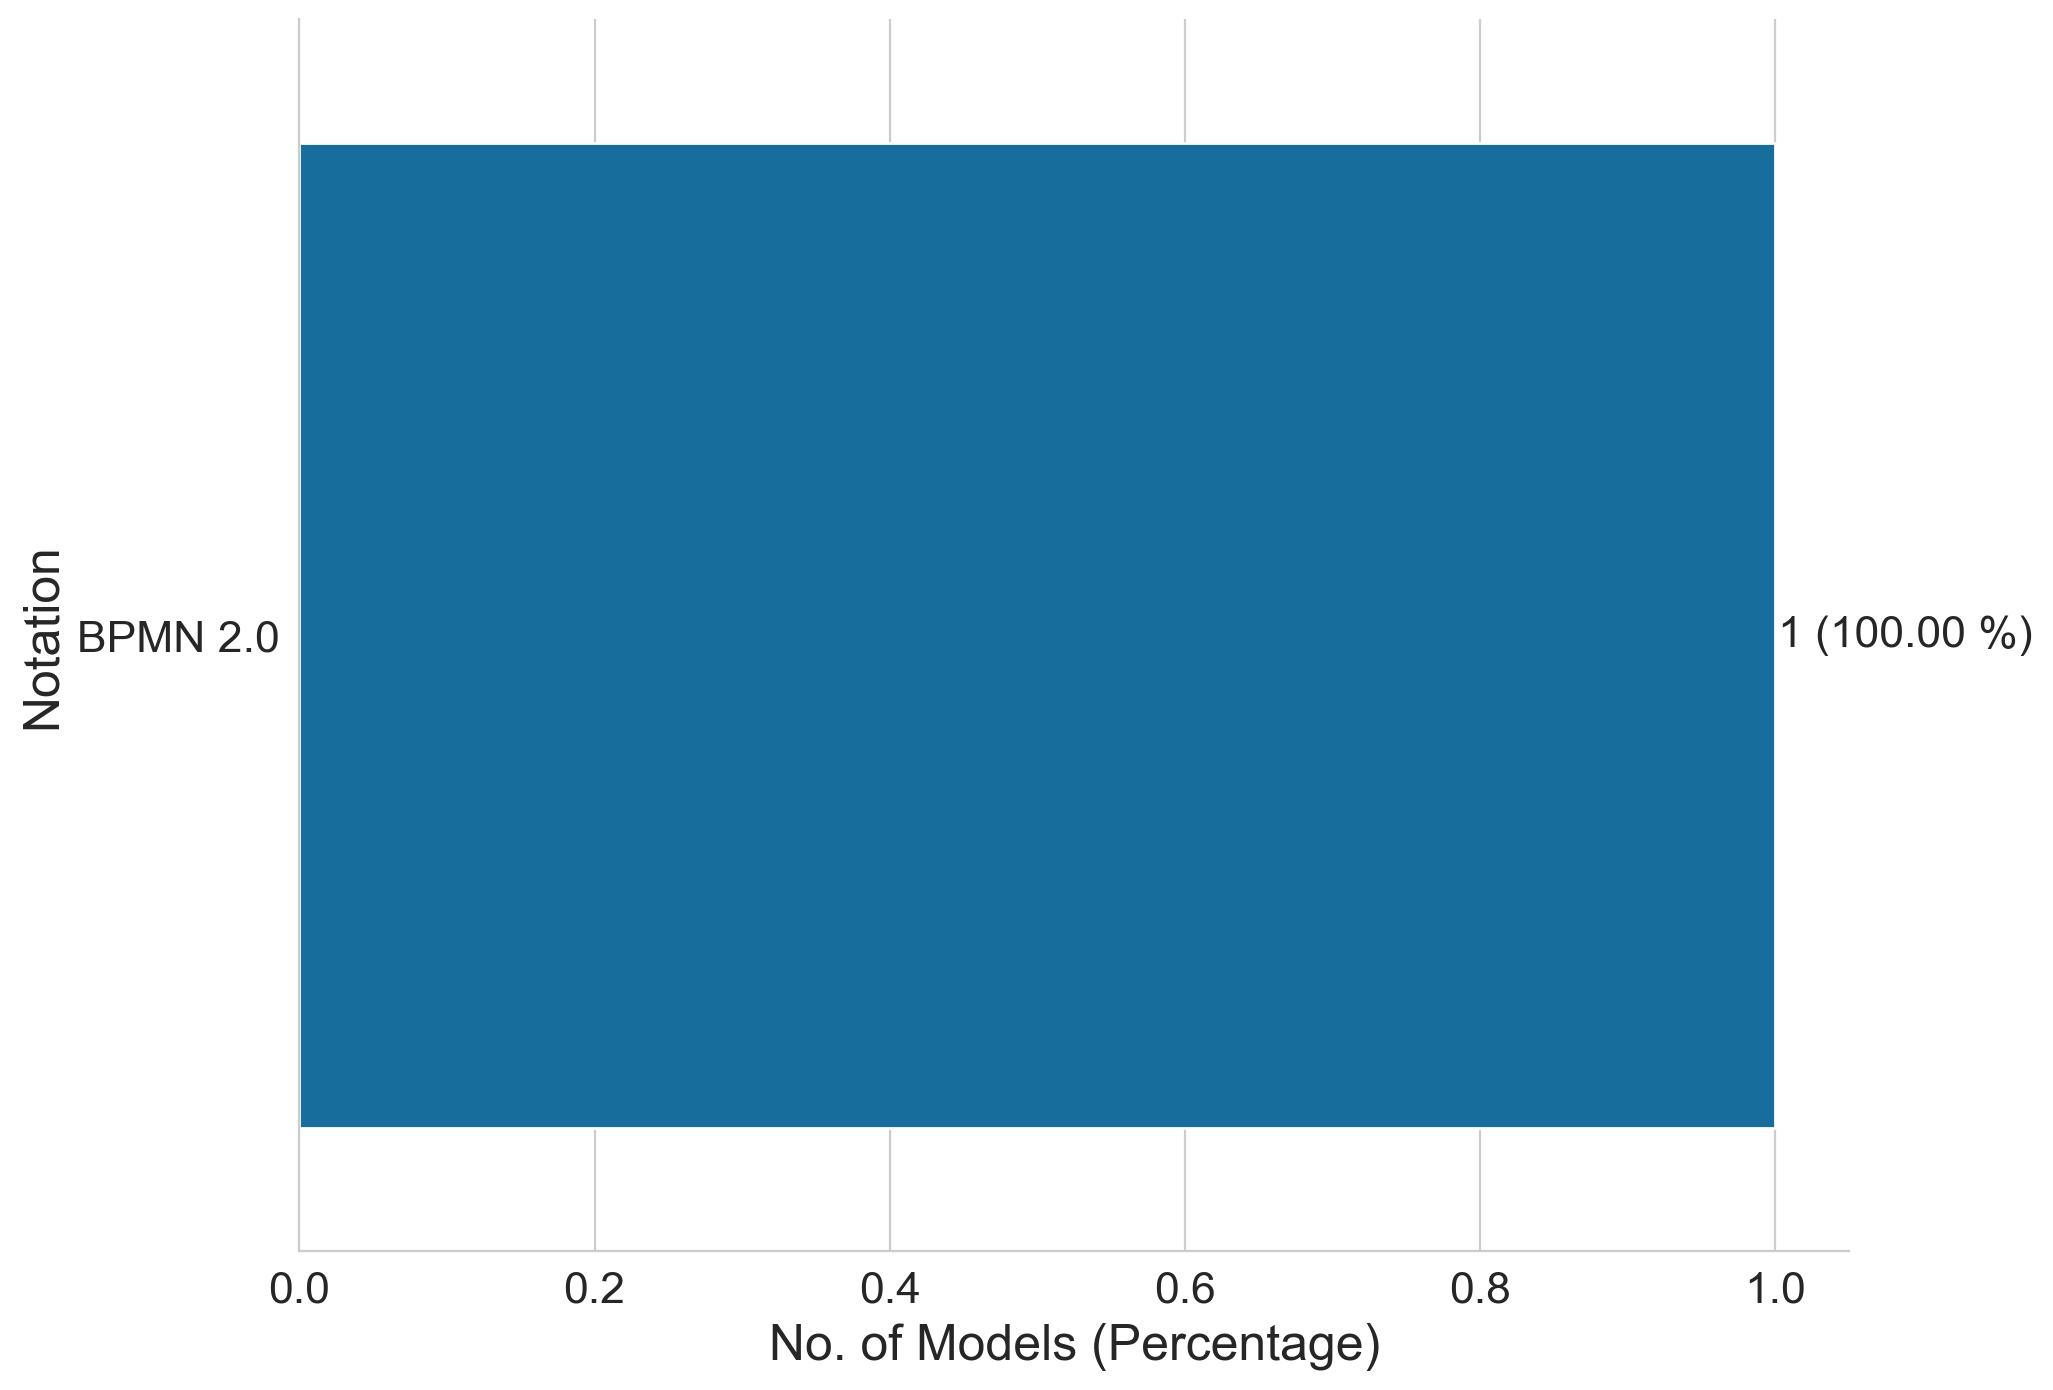

In [17]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
containers_nb = df_notations['Notation'].nunique()
ax=sns.barplot(x="Frequency",y="Notation",hue="Notation",data=df_notations,estimator = np.max, errorbar=('ci', 0),palette = sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
labels = [f'{val} ({val/ len(df_meta) * 100.0:.2f} %)' for val in df_notations["Frequency"]]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=1, labels=[label])
ax.set_xlabel('No. of Models (Percentage)', fontsize=18)
ax.set_ylabel('Notation', fontsize=18)
sns.despine()
#ax.set_xlim(0,700000)
plt.savefig(constants.FIGURES_ROOT / 'notations.pdf',transparent=True,bbox_inches = 'tight')

By using the datetime column, we can also consider the creation of models in different notations over time.

In [18]:
df_meta.datetime = pd.to_datetime(df_meta.datetime)

These are the first and the last created models in the dataset:

In [19]:
df_meta.sort_values('datetime').head(1)

revision_id  organisation_id  \
model_id                                                         
c80cf953d4544c408b1d4613c0eaa604          NaN              NaN   

                                            datetime  description  \
model_id                                                            
c80cf953d4544c408b1d4613c0eaa604 2023-12-13 12:31:19          NaN   

                                                                           name  \
model_id                                                                          
c80cf953d4544c408b1d4613c0eaa604  MHR-10-20-10 Create/Update Foundation Element   

                                 type                            namespace  
model_id                                                                    
c80cf953d4544c408b1d4613c0eaa604  NaN  http://b3mn.org/stencilset/bpmn2.0#

In [20]:
df_meta.sort_values('datetime').tail(1)

revision_id  organisation_id  \
model_id                                                         
c80cf953d4544c408b1d4613c0eaa604          NaN              NaN   

                                            datetime  description  \
model_id                                                            
c80cf953d4544c408b1d4613c0eaa604 2023-12-13 12:31:19          NaN   

                                                                           name  \
model_id                                                                          
c80cf953d4544c408b1d4613c0eaa604  MHR-10-20-10 Create/Update Foundation Element   

                                 type                            namespace  
model_id                                                                    
c80cf953d4544c408b1d4613c0eaa604  NaN  http://b3mn.org/stencilset/bpmn2.0#

Let's check the creation of models over time for the five most used notations. We leave the "Other" subgroup out.

In [21]:
df_notations = DataFilter(df_notations)
selected_notations = df_notations.filter_data("namespaces", 5)
selected_notations['Notation'] = selected_notations['Notation'].map(d_namespaces_reverse)
selected_notations

Notation  Frequency
0  http://b3mn.org/stencilset/bpmn2.0#          1

In [22]:
# handling the case where we have unknown namespaces in the dataset
# to inspect the unknown namespaces, comment the following line out:
#print(df_meta['namespace'].value_counts())
namespaces = mappings['namespaces'].keys()
df_meta['namespace'] = df_meta['namespace'].apply(lambda x: x if x in namespaces else 'Unknown')

In [23]:
df_meta_selected = df_meta[df_meta.namespace.isin(selected_notations['Notation'])].copy()
df_meta_selected['Count']= 1
df_meta_selected=df_meta_selected[['datetime','Count','namespace']].sort_values('datetime')
df_meta_selected.set_index('datetime', inplace=True)

We count the number of models created per year.

In [24]:
df_meta_selected = df_meta_selected.groupby('namespace').resample('Y').sum(numeric_only=True,min_count=1)
df_meta_selected = df_meta_selected['Count'].fillna(0)
df_meta_selected = df_meta_selected.reset_index()
df_meta_selected['Year'] = df_meta_selected['datetime'].apply(lambda x:x.year)

To ensure index consistency in the plot, we pivot the table and fill the count for missing years with 0. This step is a precaution for the case when a notation hasn't been created for a given year.

In [25]:
df_meta_selected = df_meta_selected.pivot_table(index='Year', columns='namespace', values='Count', fill_value=0)
df_meta_selected = df_meta_selected.reset_index().melt(var_name='namespace', value_name='Count', id_vars='Year')
df_meta_selected = df_meta_selected[['namespace', 'Count', 'Year']]

df_meta_selected = df_meta_selected.replace({'namespace' : d_namespaces})
df_meta_selected.head()

namespace  Count  Year
0  BPMN 2.0      1  2023

Since the number of models created before 2015 in the dataset is rather small, we visualize the numbers starting in 2015. Also, the dataset only contains models until September 2021, so we exclude 2021, too.

In [26]:
sum(df_meta['datetime'].apply(lambda x: x.year)<2015)

0

In [27]:
df_meta_selected=df_meta_selected[df_meta_selected['Year']>=2015]
df_meta_selected=df_meta_selected[df_meta_selected['Year']<2024]
df_meta_selected.head()

namespace  Count  Year
0  BPMN 2.0      1  2023

In [28]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 2000x1000 with 0 Axes>

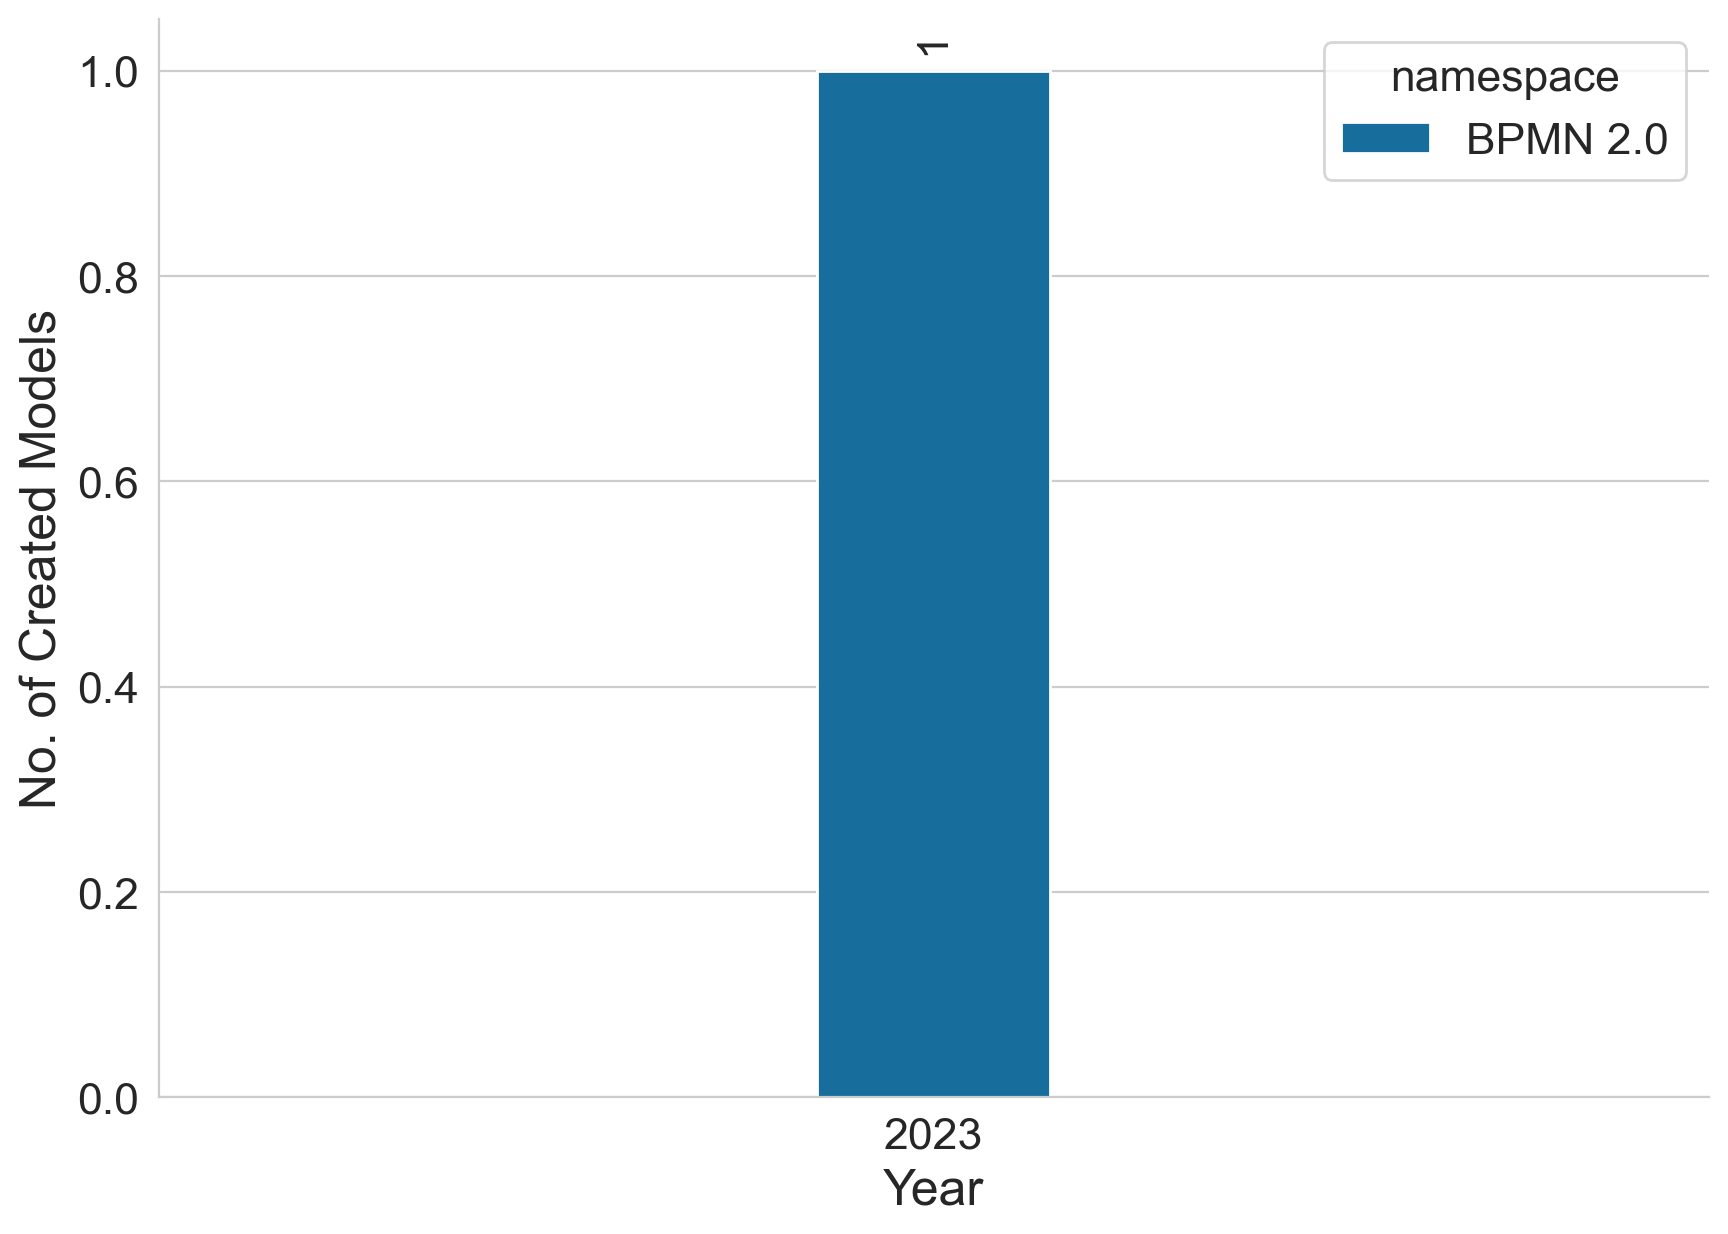

In [29]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df_meta_selected,x='Year', y='Count', hue='namespace',ax=ax)
#plt.legend(title='', loc='upper left')
change_width(ax, .15)
for container in ax.containers:
    ax.bar_label(container, padding = 6, rotation='vertical')
ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('No. of Created Models',fontsize=18)
sns.despine()

We can also visualize this as stacked plot.

In [30]:
selected_notations_short = [d_namespaces[n] for n in selected_notations['Notation']]
d_stacked = dict()
for n in selected_notations_short:
    d_stacked[n] = df_meta_selected[df_meta_selected["namespace"]==n]["Count"].values
df_stacked = pd.DataFrame(d_stacked, index=df_meta_selected.Year.unique())
df_stacked.sort_index(ascending=False,inplace=True)
df_stacked

BPMN 2.0
2023         1

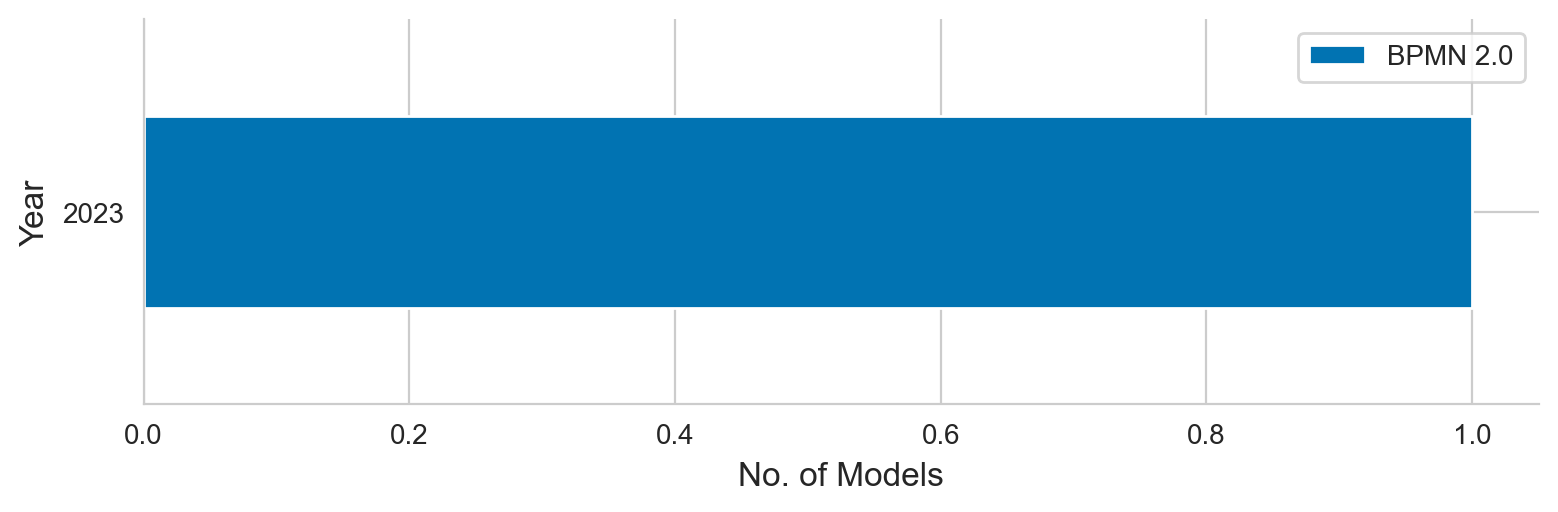

In [31]:
plt.rcParams.update({'font.size': 10})
ax = df_stacked.plot(kind='barh', stacked=True,figsize=(9,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("No. of Models",fontsize=12)
ax.set_ylabel("Year",fontsize=12)
plt.savefig(constants.FIGURES_ROOT / 'notations_over_time.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Parse BPMN 2.0 models

For further analysis, we concentrate on BPMN 2.0 models as primary used notation.

In [32]:
df_meta_bpmn = df_meta[df_meta.namespace == constants.BPMN2_NAMESPACE]
df_meta_bpmn.head()

revision_id  organisation_id  \
model_id                                                         
c80cf953d4544c408b1d4613c0eaa604          NaN              NaN   

                                            datetime  description  \
model_id                                                            
c80cf953d4544c408b1d4613c0eaa604 2023-12-13 12:31:19          NaN   

                                                                           name  \
model_id                                                                          
c80cf953d4544c408b1d4613c0eaa604  MHR-10-20-10 Create/Update Foundation Element   

                                 type                            namespace  
model_id                                                                    
c80cf953d4544c408b1d4613c0eaa604  NaN  http://b3mn.org/stencilset/bpmn2.0#

Number of BPMN 2.0 models:

In [33]:
len(df_meta_bpmn)

1

We use the BPMNModelParser to parse the BPMN 2.0 models. In case we have already parsed them, we load the parsed data from the pkl file.

In [34]:
p = parser.BpmnModelParser() # comment this line if you have already created the pkl file
df_bpmn = p.parse_model_elements() # comment this line if you have already created the pkl file
df_bpmn.to_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # comment this line if you have already created the pkl file
#df_bpmn = pd.read_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # uncomment this line if you have already created the pkl file
df_bpmn.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.84it/s]


category  \
model_id                         element_id                                                             
c80cf953d4544c408b1d4613c0eaa604 sid-B9413677-BA60-4BCB-A078-386728BCB4C5                 MessageFlow   
                                 sid-FDBC2143-DC67-4E8F-81BA-74E241AE031A  Association_Unidirectional   
                                 sid-7C8F5FC6-C6D1-4E4C-A91E-6EB7A4691A4B  Association_Unidirectional   
                                 sid-032DC142-8934-4B77-9AB1-30FA5F6E444B  Association_Unidirectional   
                                 sid-317CFD1C-6325-4BC3-B76E-7C81E60C4109  Association_Unidirectional   

                                                                                  label  \
model_id                         element_id                                               
c80cf953d4544c408b1d4613c0eaa604 sid-B9413677-BA60-4BCB-A078-386728BCB4C5  Consultation   
                                 sid-FDBC2143-DC67-4E8F-81BA-74E241AE031A          None   
                                 sid-7C8F5FC6-C6D1-4E4C-A91E-6EB7A4691A4B          None   
                                 sid-032DC142-8934-4B77-9AB1-30FA5F6E444B          None   
                                 sid-317CFD1C-6325-4BC3-B76E-7C81E60C4109          None   

                                                                          glossary_link_id  \
model_id                         element_id                                                  
c80cf953d4544c408b1d4613c0eaa604 sid-B9413677-BA60-4BCB-A078-386728BCB4C5             None   
                                 sid-FDBC2143-DC67-4E8F-81BA-74E241AE031A             None   
                                 sid-7C8F5FC6-C6D1-4E4C-A91E-6EB7A4691A4B             None   
                                 sid-032DC142-8934-4B77-9AB1-30FA5F6E444B             None   
                                 sid-317CFD1C-6325-4BC3-B76E-7C81E60C4109             None   

                                                                                                                    name  
model_id                         element_id                                                                               
c80cf953d4544c408b1d4613c0eaa604 sid-B9413677-BA60-4BCB-A078-386728BCB4C5  MHR-10-20-10 Create/Update Foundation Element  
                                 sid-FDBC2143-DC67-4E8F-81BA-74E241AE031A  MHR-10-20-10 Create/Update Foundation Element  
                                 sid-7C8F5FC6-C6D1-4E4C-A91E-6EB7A4691A4B  MHR-10-20-10 Create/Update Foundation Element  
                                 sid-032DC142-8934-4B77-9AB1-30FA5F6E444B  MHR-10-20-10 Create/Update Foundation Element  
                                 sid-317CFD1C-6325-4BC3-B76E-7C81E60C4109  MHR-10-20-10 Create/Update Foundation Element

Number of BPMN 2.0 models from the parser:

In [35]:
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

1

Number of BPMN 2.0 models from the parser after filtering out example processes, models with less than 5 elements, and models with no task, start event or end event elements:

In [36]:
df_bpmn = DataFilter(df_bpmn).filter_data("example_processes_bpmn")
df_bpmn = DataFilter(df_bpmn).filter_data("models", 5)

Filtering out example processes models...
Keeping 1 out of 1 from the dataset
Dataset has been filtered down to 1 models, a decrease of 0.00%.

Filtering out models with less than 5 elements...
Keeping 1 out of 1 from the dataset
Filtering out models with no start, end, or task elements...
Keeping 1 out of 1 from the dataset

Dataset has been filtered down to 1 models, a decrease of 0.00%.


When compared to the analysis of the dataset metadata, we notice that after the example processes filtering, the count of BPMN 2.0 models is slightly lower. This difference shows there are some empty BPMN 2.0 models in the dataset, which do not contain any elements and thus ignored during the parsing.

The total number of elements from all BPMN 2.0 models is:

In [37]:
len(df_bpmn)

109

# Languages

We use spaCy to detect the language of a model. More specifically, we use a model's element labels to decide on its language.

In [38]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("Package already installed")
except:
    print("Installing package...")
    !python -m spacy download en_core_web_sm > /dev/null
    print("\033[92m\u2713\033[0m Download and installation successful")

Installing package...

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
✓ Download and installation successful


In [39]:
ld = detector.ModelLanguageDetector(0.8) # comment this line if you have already created the pkl file
df_language = ld.get_detected_natural_language_from_bpmn_model(df_bpmn) # comment this line if you have already created the pkl file
df_language.to_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # comment this line if you have already created the pkl file
# df_language = pd.read_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # uncomment this line if you have already created the pkl file
df_language.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4232/4232 [00:56<00:00, 74.99it/s]


label  \
model_id                                                                              
002275689e0e4bdca2d44f3b58fe8d13   3D2 - Service Order Management and Monitoring...   
00478b26310845d0b91208b8ce5030ef   40G - Field Logistics Planning and Execution ...   
00575b47ccac4553be27d1fdb2ff0399   MFS-40-50-10 Accounting and Financial Closing...   
00671752a8464d3e8abf491ddd998eb0  1ZT - Managing Material Price Changes and Inve...   
00a42fef94274c0ab22dd573695f3549   DPS-160-50-30 Manage Installment Plans Admini...   

                                                                               name  \
model_id                                                                              
002275689e0e4bdca2d44f3b58fe8d13              3D2 - 02 - Time and Material Services   
00478b26310845d0b91208b8ce5030ef  40G - Field Logistics Planning and Execution -...   
00575b47ccac4553be27d1fdb2ff0399  Accounting and Financial Closing - Period End ...   
00671752a8464d3e8abf491ddd998eb0  1ZT - Managing Material Price Changes and Inve...   
00a42fef94274c0ab22dd573695f3549                   Manage Installment Plans (Print)   

                                 detected_natural_language  
model_id                                                    
002275689e0e4bdca2d44f3b58fe8d13                        en  
00478b26310845d0b91208b8ce5030ef                        en  
00575b47ccac4553be27d1fdb2ff0399                        en  
00671752a8464d3e8abf491ddd998eb0                        en  
00a42fef94274c0ab22dd573695f3549                        en

Let's plot the use of different languages across the dataset.

In [40]:
from langcodes import *
def get_language_from_code(code):
    return Language.make(language=code).display_name()

In [41]:
d_lang =  dict(Counter(df_language["detected_natural_language"]))
df_lang = pd.DataFrame.from_dict(d_lang,orient="index")
df_lang = df_lang.reset_index().rename(columns={"index": "Language",0: "No. of Models"})
df_lang["Language"] = df_lang["Language"].apply(lambda x: get_language_from_code(x))
df_lang.sort_values("No. of Models",ascending=False,inplace=True)
df_lang.reset_index(inplace=True)
df_lang.drop("index",inplace=True,axis=1)
df_lang

Language  No. of Models
0   English           4173
1    German             44
2   Swedish              7
3    French              4
4  Romanian              2
5  Croatian              1
6   Spanish              1

We only plot the 10 most common languages.

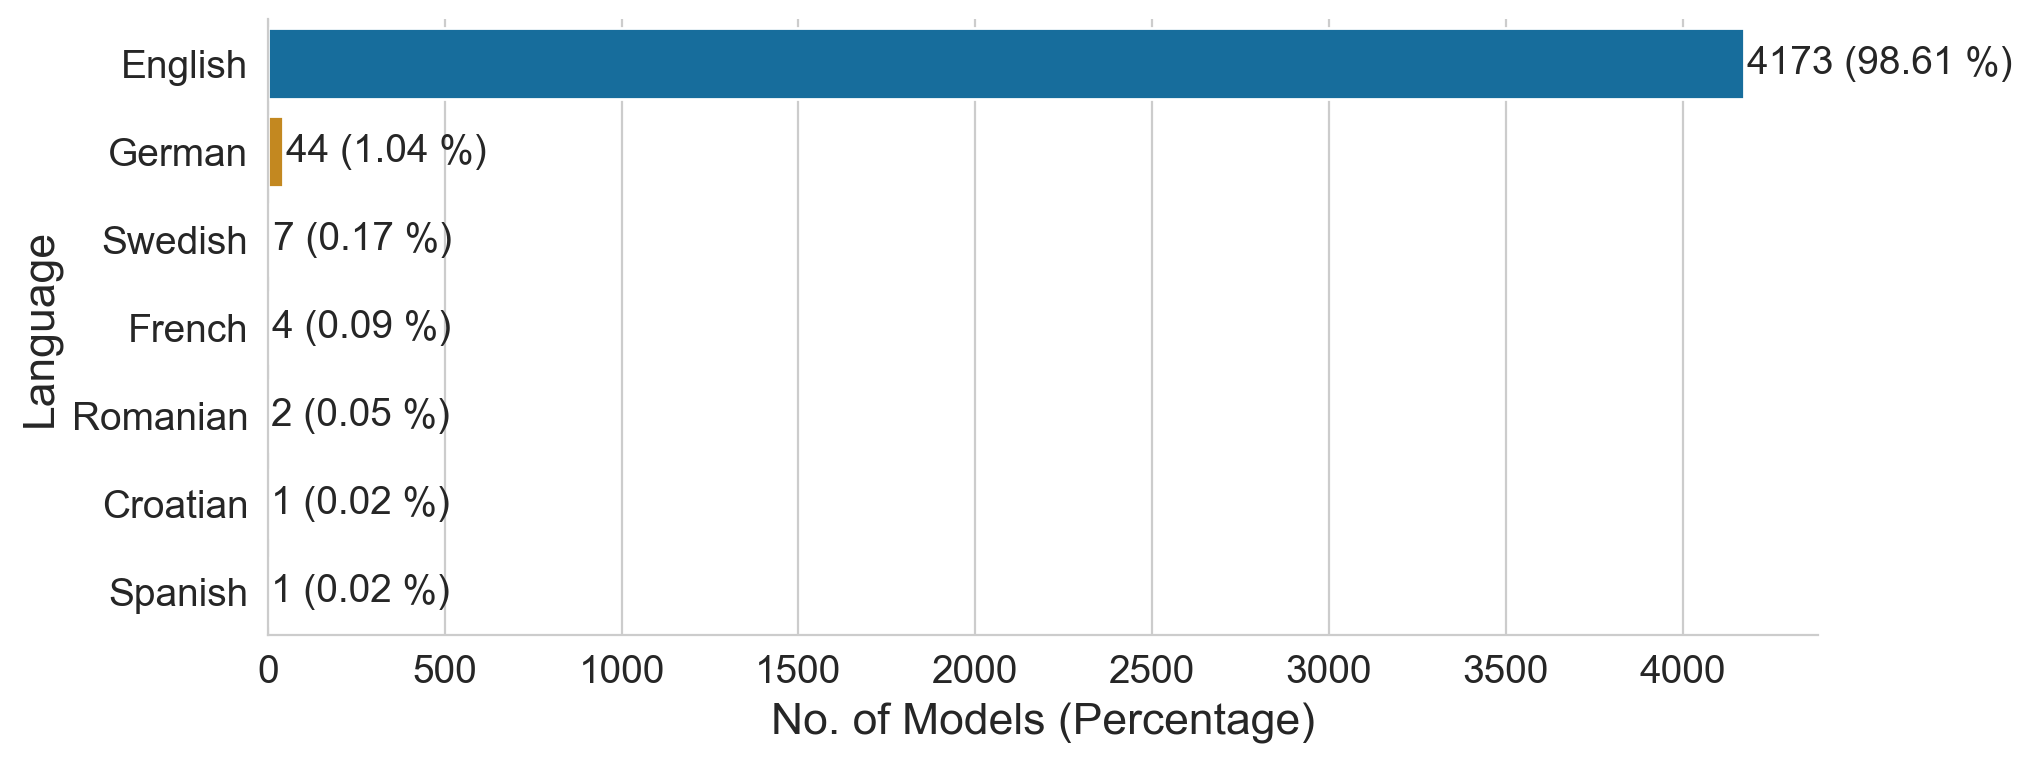

In [42]:
nr_most_common = 10
total = df_lang['No. of Models'].sum()
df_lang = df_lang.iloc[:nr_most_common]
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
ax = sns.barplot(x="No. of Models", y="Language", hue="Language", data=df_lang)
labels = [f'{val} ({val/ total * 100.0:.2f} %)' for val in df_lang['No. of Models']]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=1, labels=[label])
#ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=)
ax.set_xlabel("No. of Models (Percentage)",fontsize=16)
ax.set_ylabel("Language",fontsize=16)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'languages.pdf',transparent=True,bbox_inches = 'tight')

# Element types 

Next, we want to examine the usage of element types in the BPMN models.

In [43]:
def get_element_count(df_model):
    cnts = dict(Counter(df_model["category"].values))
    cnts["total_count"] = sum(cnts.values())
    return cnts

In [44]:
cnt_elements = pd.DataFrame.from_records(get_element_count(df_bpmn.loc[s]) for s in tqdm(df_bpmn.index.unique("model_id"))).fillna(0, downcast="infer") # comment this line if you have already created the pkl file
cnt_elements.to_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # comment this line if you have already created the pkl file
# cnt_elements = pd.read_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # uncomment this line if you have already created the pkl file
cnt_elements.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4232/4232 [00:00<00:00, 4871.01it/s]


Association_Undirected  SequenceFlow  Pool  Lane  DataObject  EndNoneEvent  \
0                       7            48     1     7           2             1   
1                       0            18     1     7           0             1   
2                       0             3     1     1           0             1   
3                       1            12     2     2           0             2   
4                       0             5     1     2           0             1   

   Subprocess  TextAnnotation  CollapsedSubprocess  Task  ParallelGateway  \
0           2              15                    7    19                4   
1           0               0                    0    17                0   
2           0               0                    0     2                0   
3           0               5                    0     8                0   
4           0               0                    0     4                0   

   Exclusive_Databased_Gateway  StartNoneEvent  total_count  \
0                            6               1          120   
1                            0               1           45   
2                            0               1            9   
3                            0               2           34   
4                            0               1           14   

   IntermediateEvent  MessageFlow  IntermediateMessageEventThrowing  \
0                  0            0                                 0   
1                  0            0                                 0   
2                  0            0                                 0   
3                  0            0                                 0   
4                  0            0                                 0   

   IntermediateMessageEventCatching  Association_Unidirectional  \
0                                 0                           0   
1                                 0                           0   
2                                 0                           0   
3                                 0                           0   
4                                 0                           0   

   CollapsedPool  StartTimerEvent  ITSystem  StartMessageEvent  \
0              0                0         0                  0   
1              0                0         0                  0   
2              0                0         0                  0   
3              0                0         0                  0   
4              0                0         0                  0   

   IntermediateTimerEvent  Group  InclusiveGateway  EndMessageEvent  \
0                       0      0                 0                0   
1                       0      0                 0                0   
2                       0      0                 0                0   
3                       0      0                 0                0   
4                       0      0                 0                0   

   IntermediateLinkEventCatching  IntermediateLinkEventThrowing  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   EventbasedGateway  Message  EndMultipleEvent  ComplexGateway  \
0                  0        0                 0               0   
1                  0        0                 0               0   
2                  0        0                 0               0   
3                  0        0                 0               0   
4                  0        0                 0               0   

   StartMultipleEvent  StartConditionalEvent  
0                   0                      0  
1                   0                      0  
2                   0                      0  
3                   0     

These are the statistics of the different element types per model:

In [45]:
# print(cnt_elements.columns)
# cnt_elements.drop(columns=["total_count","gdottedline","gdashedline","gtext","gellipse","gdiamond","grect"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()
cnt_elements.drop(columns=["total_count"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()

count    4232.000000
mean        7.050567
std         2.007030
min         4.000000
25%         6.000000
50%         6.000000
75%         7.000000
max        21.000000
dtype: float64

Thus, on average, a BPMN 2.0 model contains 11.3 different element types (median: 11).

We can also investigate the number of models that contain at least one instance of a particular element type. This gives us an indication of which element types are most important in practice.

In [46]:
df_cnts = (
    df_bpmn.groupby("model_id").category
    .value_counts()
    .to_frame("count")
    .unstack()
    .droplevel(0, axis='columns') # drop first level column level "count" that unstack produces
    .fillna(0, downcast="infer")
)
df_cnts.head()

category                          Association_Undirected  \
model_id                                                   
002275689e0e4bdca2d44f3b58fe8d13                       7   
00478b26310845d0b91208b8ce5030ef                       0   
00575b47ccac4553be27d1fdb2ff0399                       0   
00671752a8464d3e8abf491ddd998eb0                       1   
00a42fef94274c0ab22dd573695f3549                       0   

category                          Association_Unidirectional  CollapsedPool  \
model_id                                                                      
002275689e0e4bdca2d44f3b58fe8d13                           0              0   
00478b26310845d0b91208b8ce5030ef                           0              0   
00575b47ccac4553be27d1fdb2ff0399                           0              0   
00671752a8464d3e8abf491ddd998eb0                           0              0   
00a42fef94274c0ab22dd573695f3549                           0              0   

category                          CollapsedSubprocess  ComplexGateway  \
model_id                                                                
002275689e0e4bdca2d44f3b58fe8d13                    7               0   
00478b26310845d0b91208b8ce5030ef                    0               0   
00575b47ccac4553be27d1fdb2ff0399                    0               0   
00671752a8464d3e8abf491ddd998eb0                    0               0   
00a42fef94274c0ab22dd573695f3549                    0               0   

category                          DataObject  EndMessageEvent  \
model_id                                                        
002275689e0e4bdca2d44f3b58fe8d13           2                0   
00478b26310845d0b91208b8ce5030ef           0                0   
00575b47ccac4553be27d1fdb2ff0399           0                0   
00671752a8464d3e8abf491ddd998eb0           0                0   
00a42fef94274c0ab22dd573695f3549           0                0   

category                          EndMultipleEvent  EndNoneEvent  \
model_id                                                           
002275689e0e4bdca2d44f3b58fe8d13                 0             1   
00478b26310845d0b91208b8ce5030ef                 0             1   
00575b47ccac4553be27d1fdb2ff0399                 0             1   
00671752a8464d3e8abf491ddd998eb0                 0             2   
00a42fef94274c0ab22dd573695f3549                 0             1   

category                          EventbasedGateway  \
model_id                                              
002275689e0e4bdca2d44f3b58fe8d13                  0   
00478b26310845d0b91208b8ce5030ef                  0   
00575b47ccac4553be27d1fdb2ff0399                  0   
00671752a8464d3e8abf491ddd998eb0                  0   
00a42fef94274c0ab22dd573695f3549                  0   

category                          Exclusive_Databased_Gateway  Group  \
model_id                                                               
002275689e0e4bdca2d44f3b58fe8d13                            6      0   
00478b26310845d0b91208b8ce5030ef                            0      0   
00575b47ccac4553be27d1fdb2ff0399                            0      0   
00671752a8464d3e8abf491ddd998eb0                            0      0   
00a42fef94274c0ab22dd573695f3549                            0      0   

category                          ITSystem  InclusiveGateway  \
model_id                                                       
002275689e0e4bdca2d44f3b58fe8d13         0                 0   
00478b26310845d0b91208b8ce5030ef         0                 0   
00575b47ccac4553be27d1fdb2ff0399         0                 0   
00671752a8464d3e8abf491ddd998eb0         0                 0   
00a42fef94274c0ab22dd573695f3549         0                 0   

category                          IntermediateEvent  \
model_id                                              
002275689e0e4bdca2d44f3b58fe8d13                  0   
00478b26310845d0b91208b8ce5030ef                  0   
00575b47ccac4553be27

In [47]:
# df_cnts.drop(["gdashedline","gdiamond","gdottedline","gellipse","grect","gtext"],axis=1,inplace=True)

In [48]:
df_freq = (
    df_cnts
    .gt(0)
    .sum()
    #.div(len(df_cnts))
    .sort_values(ascending=False)
    .to_frame("frequency")
    .reset_index()
    .rename(columns={"index":"category"})
)
df_freq[df_freq["frequency"]/len(df_cnts) < 0.1].head()

category  frequency
10                       MessageFlow        341
11                   ParallelGateway        266
12  IntermediateMessageEventCatching        232
13                        DataObject        219
14        Association_Unidirectional        167

In [49]:
df_freq = df_freq[df_freq["frequency"]/len(df_cnts) >= 0.1]
from stringcase import sentencecase
df_freq["category"] = df_freq["category"].apply(lambda x: sentencecase(x)).replace({"I t system": "IT system"})
df_freq["category"] = df_freq["category"].apply(lambda x: x.strip())

/var/folders/rn/8_jypvhj2jv1m35k5h8ygpyh0000gn/T/ipykernel_53712/321567440.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="frequency", y="category",data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind", n_colors=containers_nb))


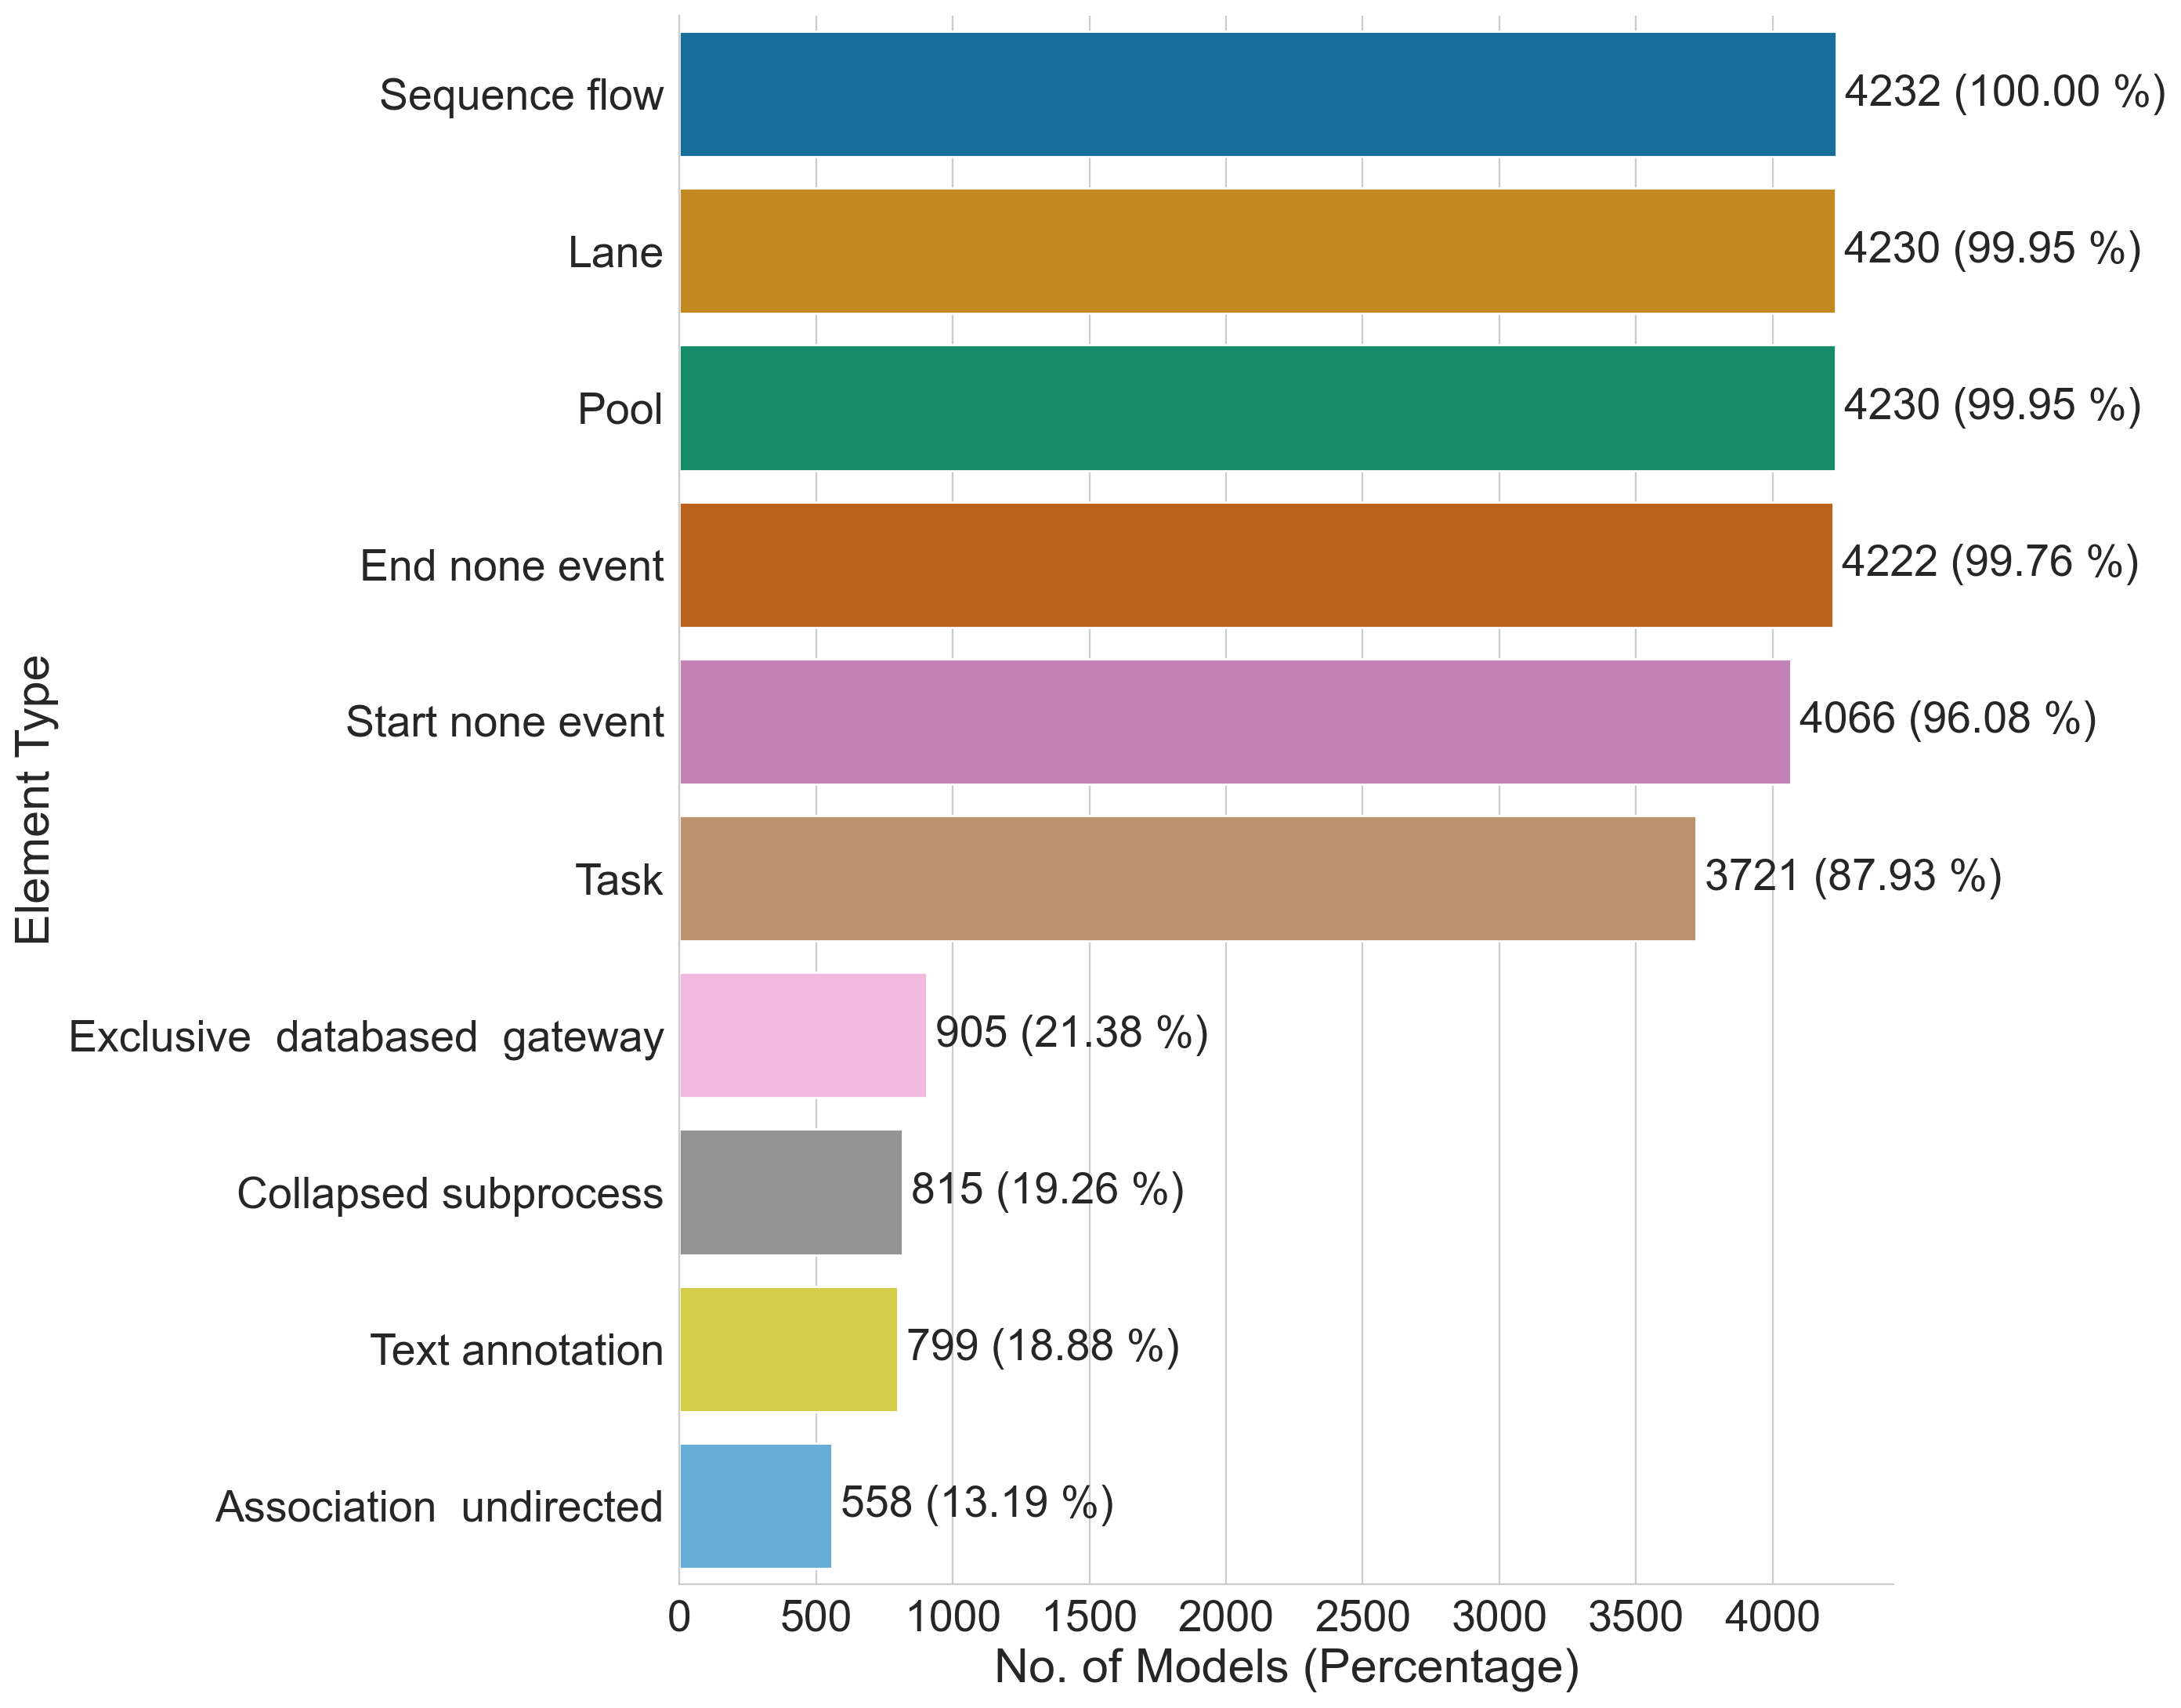

In [50]:
plt.figure(figsize=(10,13)) # 10,13
plt.rcParams.update({'font.size': 20}) # 22
containers_nb = df_freq['category'].nunique()
# for running analysis on smaller datasets, the hue setting must be omitted, otherwise graph won't be created.
# reason: number of containers represents the original overall count of categories (from the first dataframe), not the filtered/manipulated ones. As a result, more containers are being iterated over as should be.
# thoroughly investigated and origin of problem currently unknown, maybe pandas v2 is necessary?
#if len(df_meta_bpmn) > 4000: # arbitrary value
#    ax = sns.barplot(x="frequency", y="category",hue="category", legend=False, data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind", n_colors=containers_nb))
#else:
ax = sns.barplot(x="frequency", y="category",data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind", n_colors=containers_nb))
total = len(df_cnts)
labels = [f'{val} ({val / total * 100.0:.2f} %)' for val in df_freq['frequency']]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=4, labels=[label])
ax.set_xlabel("No. of Models (Percentage)",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'elements_usage.pdf',transparent=True,bbox_inches = 'tight')

# Business objects

Now, let's take a look at business objects in BPMN 2.0 diagrams, also known as dictionary items or glossary entries. The dictionary is a Signavio feature that allows the user to enable reusability of BPMN diagram elements by dragging them out of a list, instead of having to recreate them for each diagram. That way, the creation of diagrams is made less time consuming, while also ensuring name and attributes consistency for elements that are recurrent through an organisation's processes (for example, IT system).

In [51]:
df_bpmn.head()

category  \
model_id                         element_id                           
002275689e0e4bdca2d44f3b58fe8d13 78          Association_Undirected   
                                 35                    SequenceFlow   
                                 67                    SequenceFlow   
                                 1                             Pool   
                                 119                           Lane   

                                                                                     label  \
model_id                         element_id                                                  
002275689e0e4bdca2d44f3b58fe8d13 78                                                   None   
                                 35                                                          
                                 67                                                          
                                 1           3D2 - Service Order Management and Monitoring   
                                 119                                            Controller   

                                            glossary_link_id  \
model_id                         element_id                    
002275689e0e4bdca2d44f3b58fe8d13 78                     None   
                                 35                     None   
                                 67                     None   
                                 1                      None   
                                 119                    None   

                                                                              name  
model_id                         element_id                                         
002275689e0e4bdca2d44f3b58fe8d13 78          3D2 - 02 - Time and Material Services  
                                 35          3D2 - 02 - Time and Material Services  
                                 67          3D2 - 02 - Time and Material Services  
                                 1           3D2 - 02 - Time and Material Services  
                                 119         3D2 - 02 - Time and Material Services

First, we calculate and visualize the total counts of business objects in the dataset.

In [52]:
total_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") & (df_bpmn['glossary_link_id'] != "None")]

This give us a total count of:

In [53]:
total_bos_count = len(total_bos)
total_bos_count

13033

In [54]:
len(df_bpmn)

106156

When compared to the total number of elements, that would be about:

In [55]:
print(f"{round(total_bos_count/len(df_bpmn)*100, 2)}%")

12.28%


Next, let's take a look at how many models have at least one glossary link.

In [56]:
models_w_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") 
    & (df_bpmn['glossary_link_id'] != "None")].groupby(level=['model_id']).size()

This is the number of models with at least one element from the dictionary:

In [57]:
len(models_w_bos)

2246

The highest number of glossary links used in one model:

In [58]:
models_w_bos.max()

89

Now, let's take a look at how many unique glossary items are present in the dataset, and compare it to the overall count.

In [59]:
unique_bo_ids_count = len(df_bpmn['glossary_link_id'].unique())
unique_bo_ids_count

4375

In [60]:
print(f"{round(unique_bo_ids_count/total_bos_count*100, 2)}%")

33.57%


This is the percentage of unique glossary items in the dataset. In other terms, it gives us a rough idea of how often dictionary items are being reused in the models.

We also want to find out what is the most used type of dictionary item. For that, we create a plot:

/var/folders/rn/8_jypvhj2jv1m35k5h8ygpyh0000gn/T/ipykernel_53712/713024387.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb))
/var/folders/rn/8_jypvhj2jv1m35k5h8ygpyh0000gn/T/ipykernel_53712/713024387.py:10: UserWarning: 
The palette list has fewer values (8) than needed (34) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(y="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb))


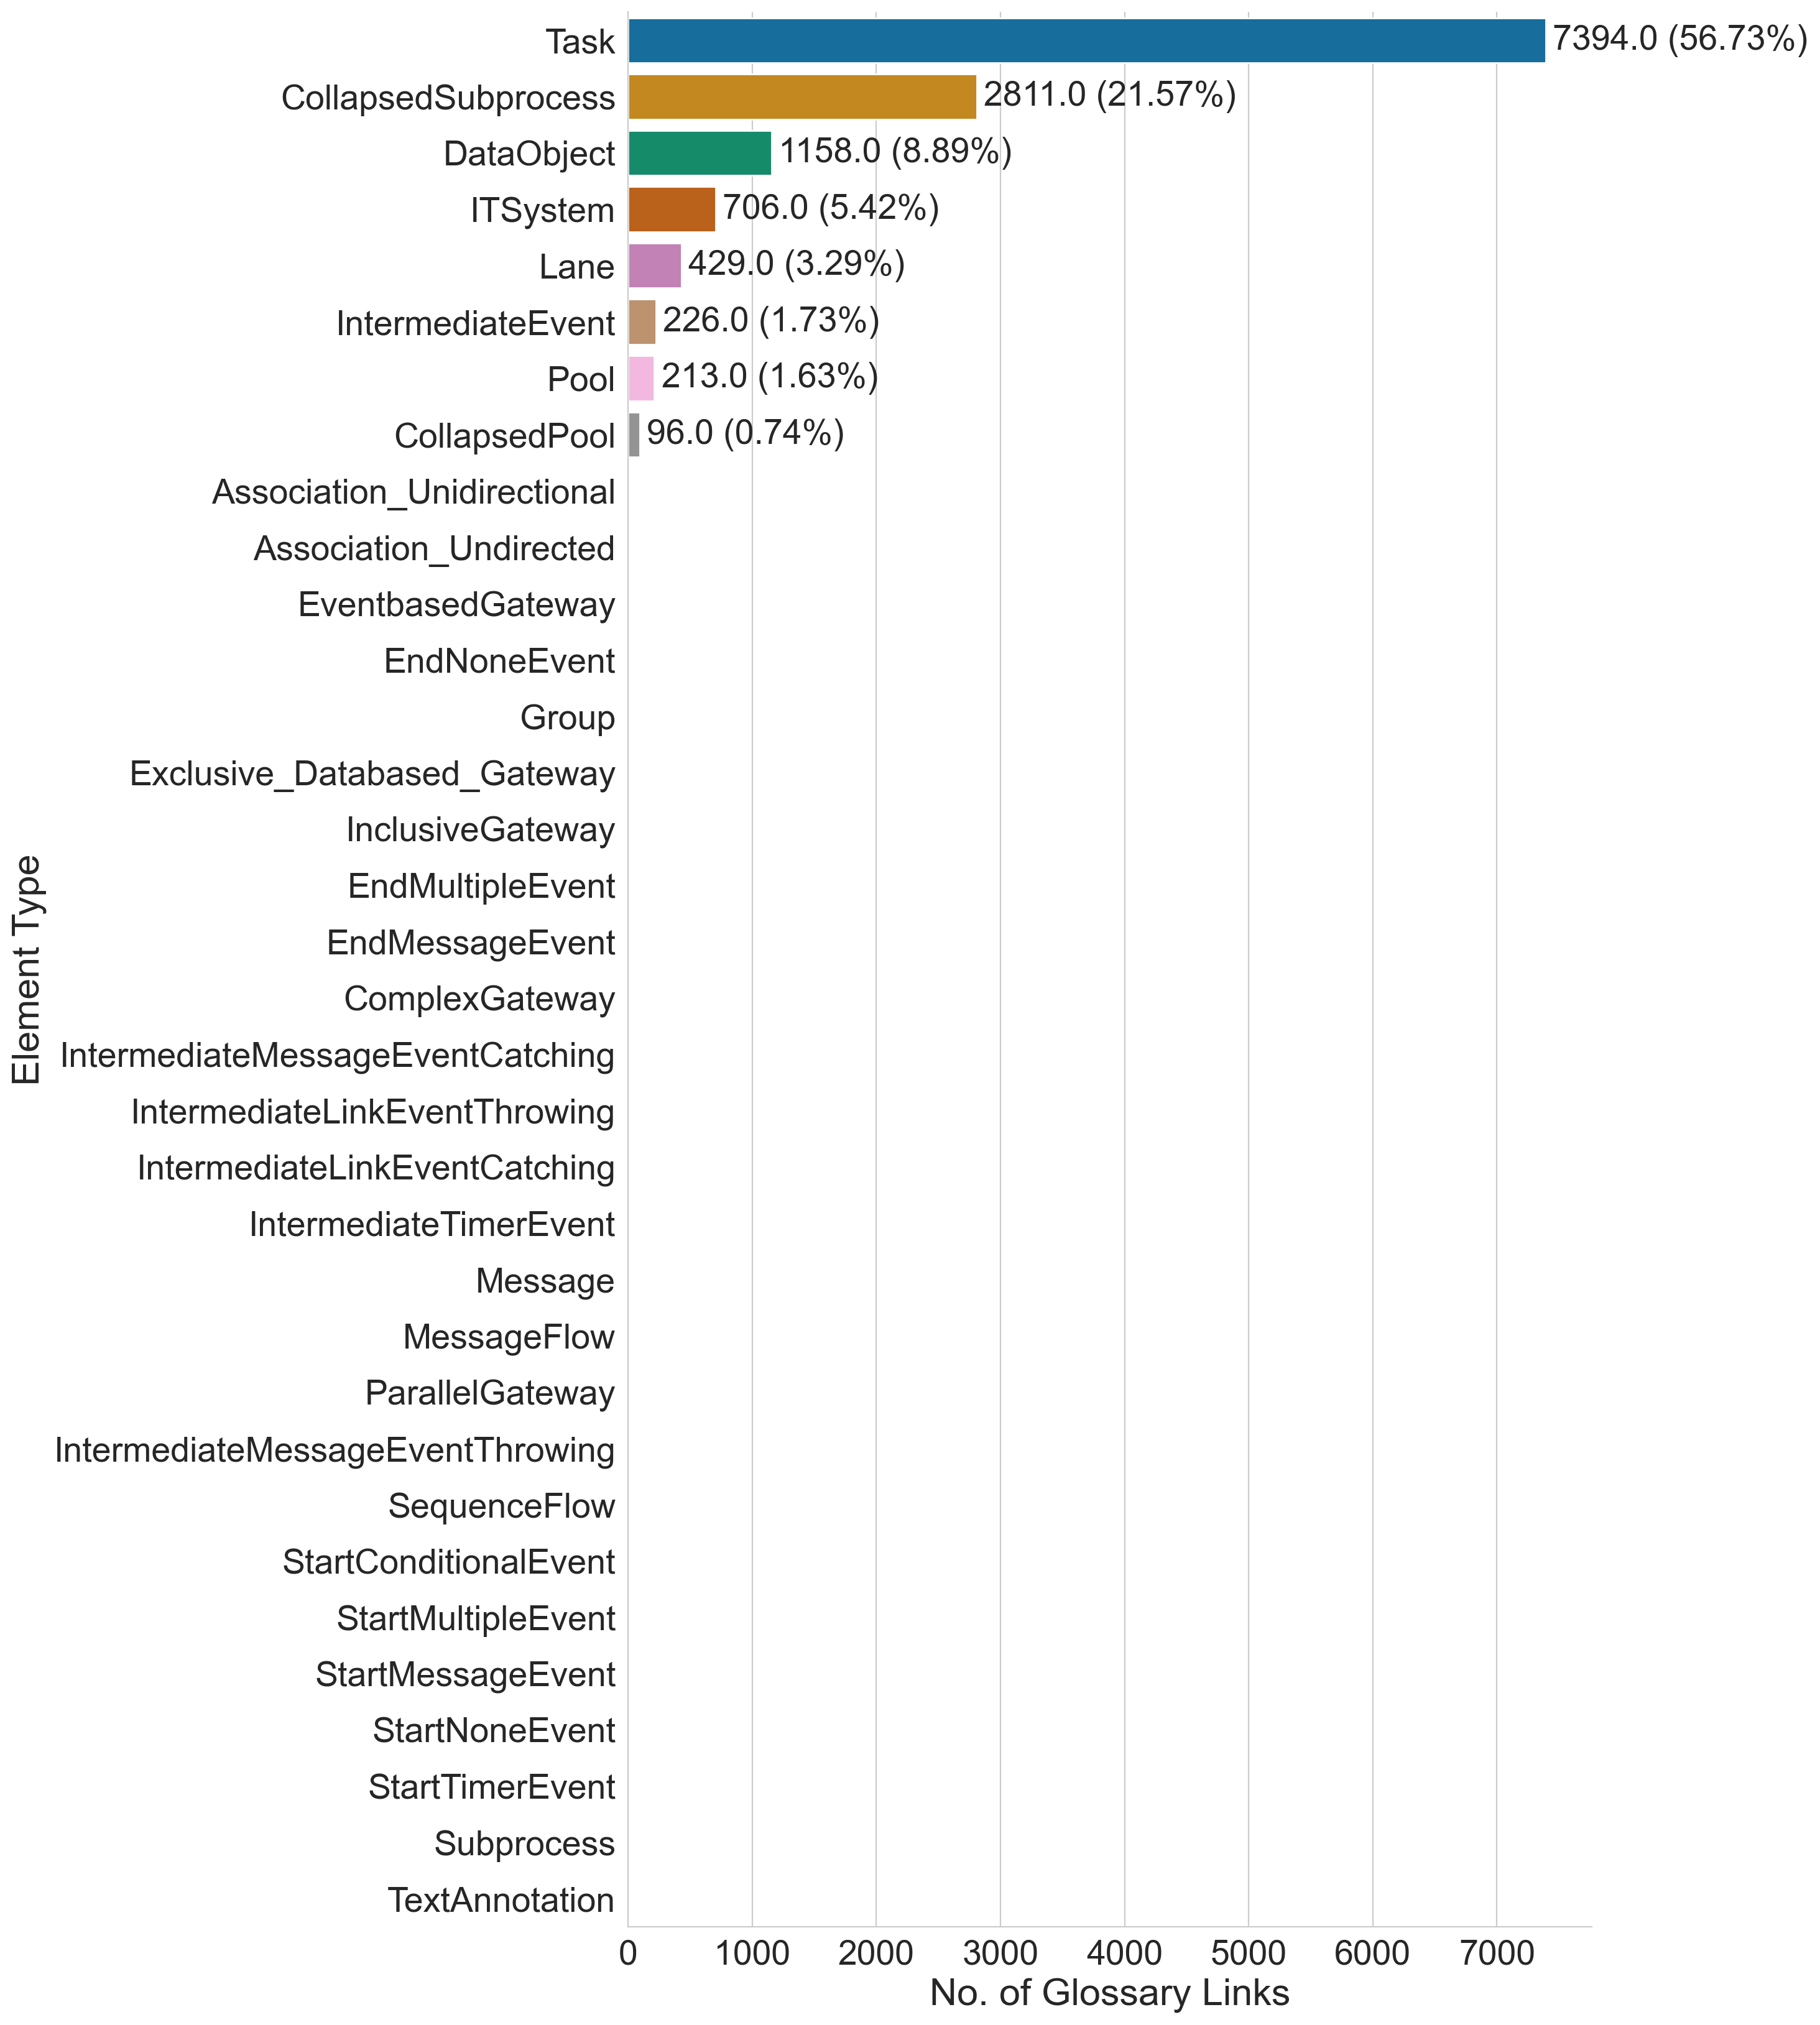

In [61]:
plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 20})
containers_nb = total_bos['category'].nunique()
# for running analysis on smaller datasets, the hue setting must be omitted, otherwise graph won't be created.
# reason: number of containers represents the original overall count of categories (from the first dataframe), not the filtered/manipulated ones. As a result, more containers are being iterated over as should be.
# thoroughly investigated and origin of problem currently unknown, maybe pandas v2 is necessary?
#if len(df_meta_bpmn) > 4000: # arbitrary value
#    ax = sns.countplot(y="category", hue="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb),legend=False)
#else:
ax = sns.countplot(y="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb))
labels = []
for container in ax.containers:
    for val in container:
        labels.append(f'{val.get_width()} ({val.get_width()/total_bos_count*100.0:.2f}%)')
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=4, labels=[label])
sns.despine()
ax.set_xlabel("No. of Glossary Links",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.savefig(constants.FIGURES_ROOT / 'glossary_elements_usage.pdf',transparent=True,bbox_inches = 'tight')

For the next analysis, let's concentrate on one particular category, 'ITSystem'. First, let's see how many models with 'ITSystem' entries we have in the dataset. In this way, we can evaluate how many different IT systems a process model is using.

In [62]:
its_bos = total_bos[total_bos['category'] == 'ITSystem']
its_bos = its_bos.reset_index()
its_bos_count = its_bos.groupby('model_id')['glossary_link_id'].count().reset_index()

This is the count of models using at least one dictionary item of type 'ITSystem' in the dataset.

In [63]:
len(its_bos_count)

50

Let's plot the distribution of these glossary entries across models. For the sake of readability, we aggregate all models using more than 7 IT Systems elements in the 'Other' category.

In [64]:
its_count_per_model = its_bos_count['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

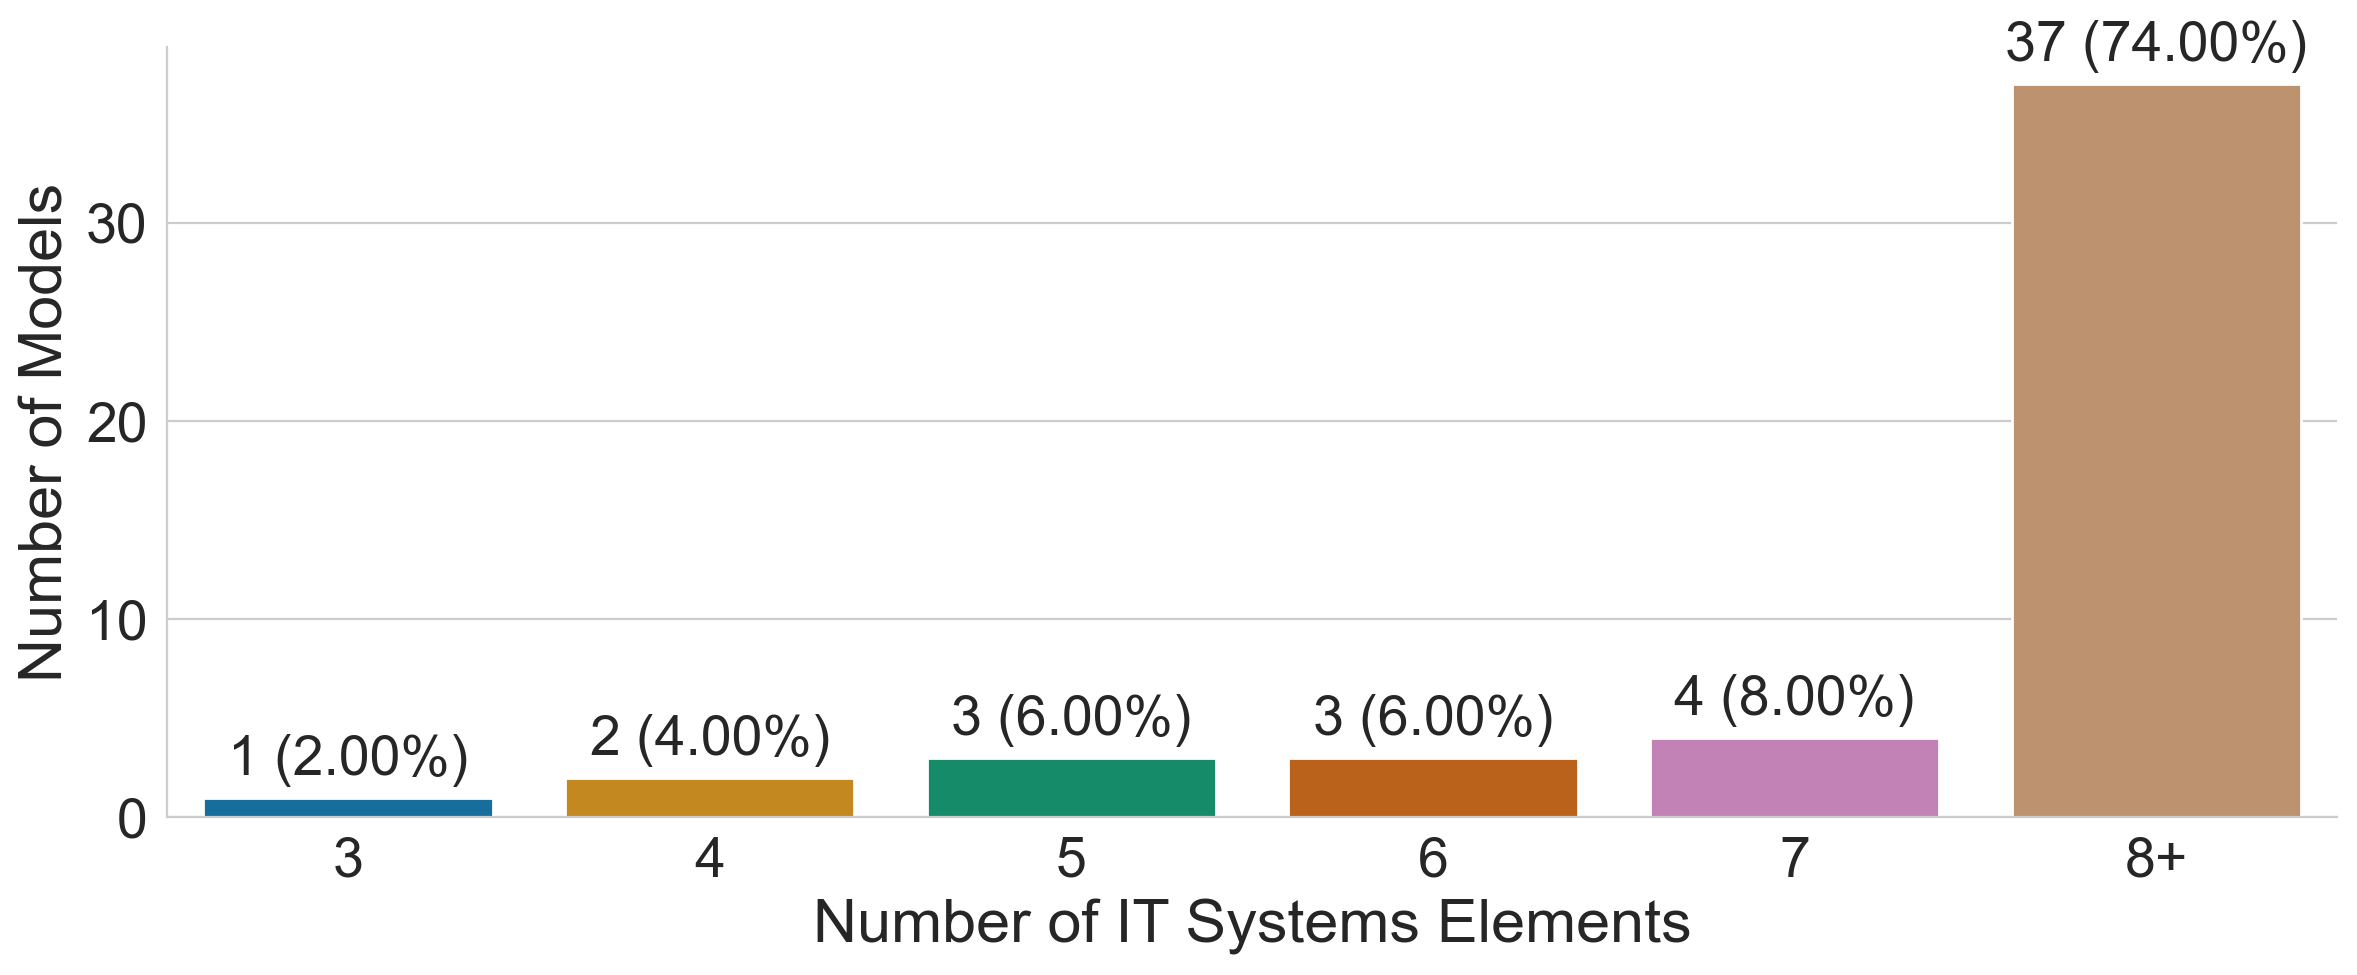

In [65]:
if len(its_bos_count) == 0:
    pass
else:
    plt.figure(figsize=(14, 5))
    containers_nb = its_count_per_model.index.nunique()
    ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,hue=its_count_per_model.index,palette=sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
    total = len(its_bos_count)
    labels = [f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values]
    for container, label in zip(ax.containers, labels):
        ax.bar_label(container, label_type='edge', padding=4, labels=[label])
    sns.despine()
    ax.set_xlabel("Number of IT Systems Elements",fontsize=22)
    ax.set_ylabel("Number of Models",fontsize=22)
    plt.savefig(constants.FIGURES_ROOT / 'distribution_itsystems.pdf',transparent=True,bbox_inches = 'tight')

Now, let's see how many of these IT Systems might in fact be referring to the same item, but involved at different stages of the process modelling.

In [66]:
its_bos = its_bos.groupby('model_id')['glossary_link_id'].nunique().reset_index()
its_count_per_model = its_bos['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()
its_count_per_model

2    11
3    39
Name: glossary_link_id, dtype: int64

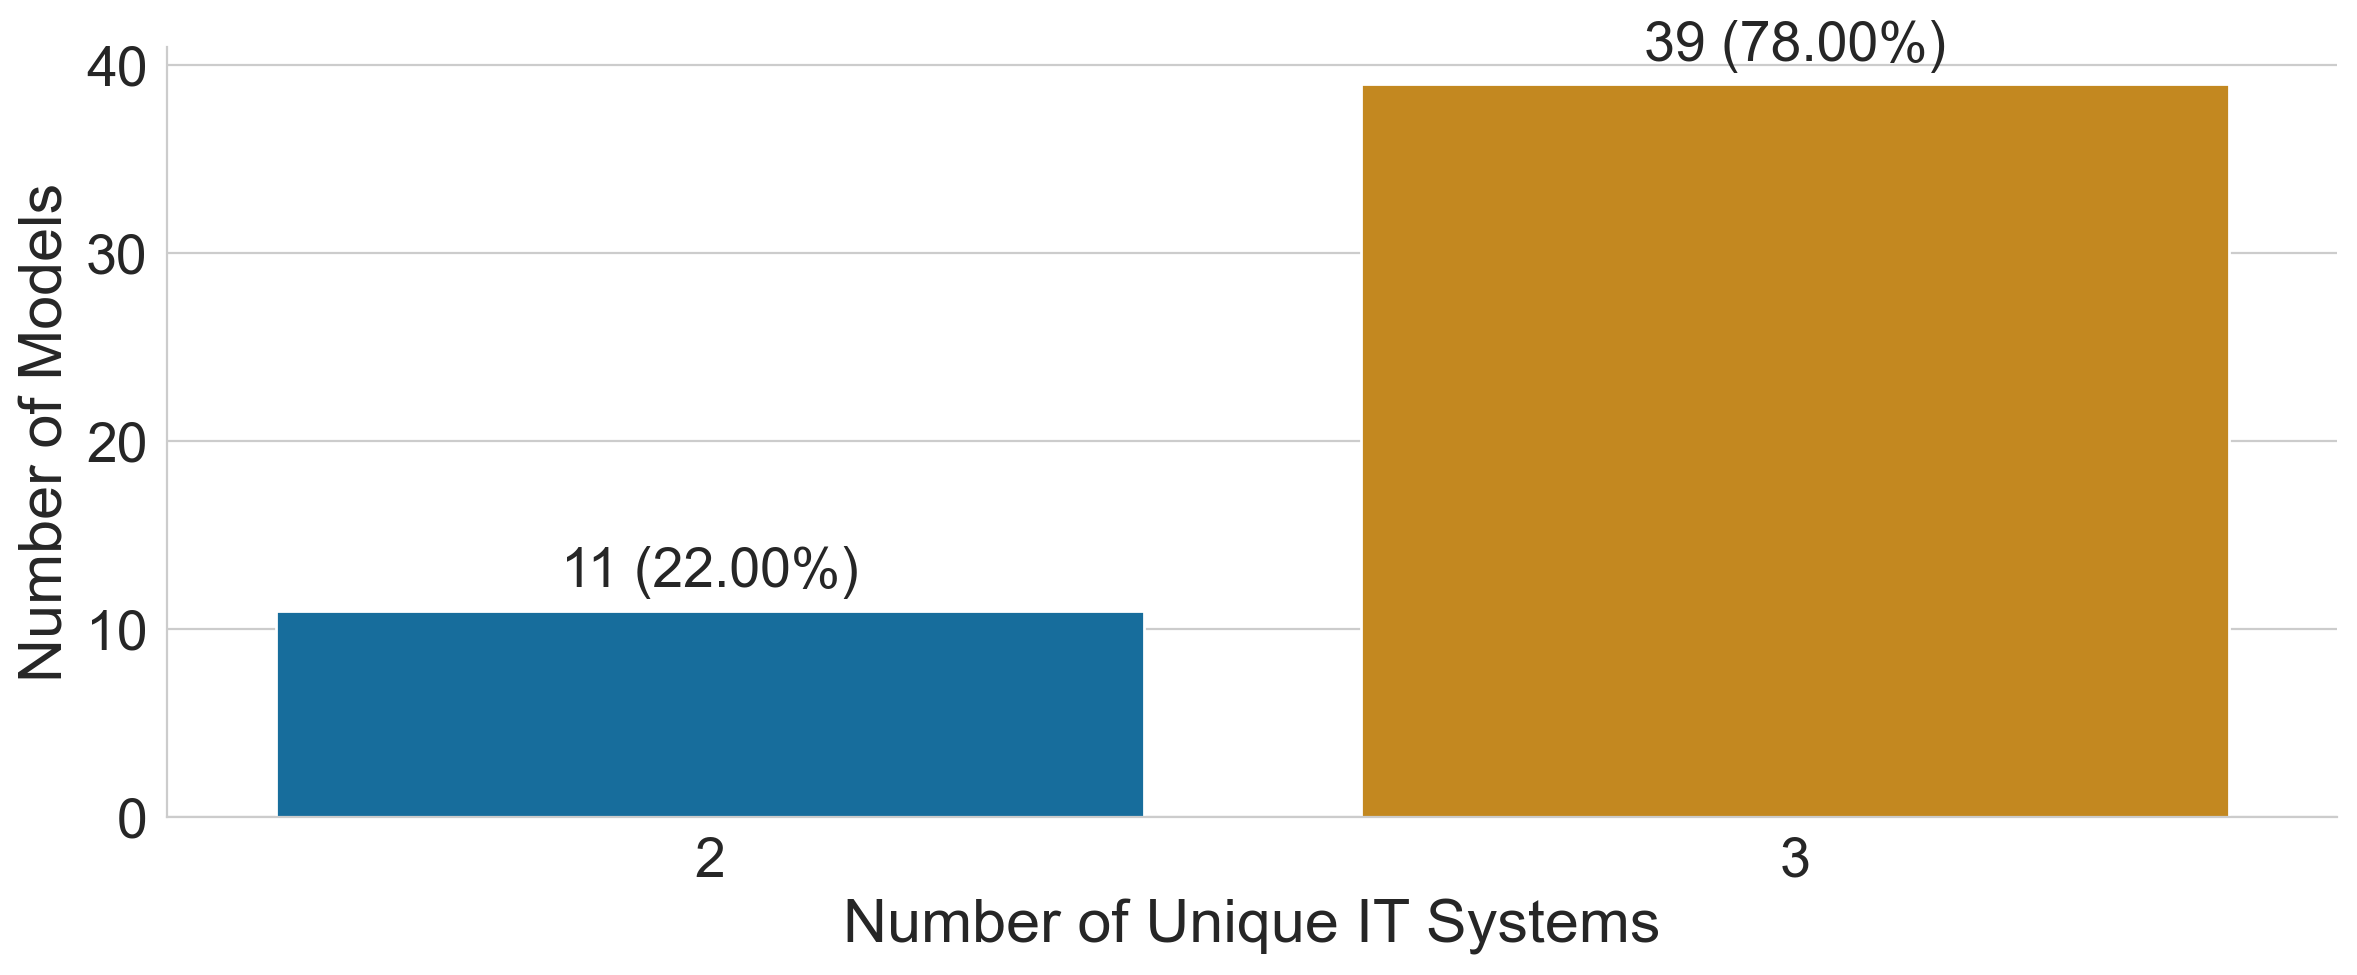

In [67]:
if len(its_bos_count) == 0:
    pass
else:
    plt.figure(figsize=(14, 5))
    containers_nb = its_count_per_model.index.nunique()
    ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,hue=its_count_per_model.index,palette=sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
    total = len(its_bos)
    labels = [f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values]
    for container, label in zip(ax.containers, labels):
        ax.bar_label(container, label_type='edge', padding=4, labels=[label])
    sns.despine()
    ax.set_xlabel("Number of Unique IT Systems",fontsize=22)
    ax.set_ylabel("Number of Models",fontsize=22)
    plt.savefig(constants.FIGURES_ROOT / 'distribution_unique_itsystems.pdf',transparent=True,bbox_inches = 'tight')

As expected, we can observe that an overwhelming majority of models is using only one IT System, regardless of the number of times it is involved in a single process model.

# Elements

These are the statistics of the number of elements per model:

In [68]:
cnt_elements.total_count.describe()

count    4232.000000
mean       25.084121
std        27.007654
min         7.000000
25%         9.000000
50%        15.000000
75%        30.000000
max       290.000000
Name: total_count, dtype: float64

These are the statistics of the number of elements per model by element type:

In [69]:
cnt_elements.describe().transpose().head()

count      mean        std  min  25%  50%    75%  \
Association_Undirected  4232.0  0.504962   2.210282  0.0  0.0  0.0   0.00   
SequenceFlow            4232.0  9.297732  10.324731  2.0  3.0  6.0  11.25   
Pool                    4232.0  1.100662   0.407075  0.0  1.0  1.0   1.00   
Lane                    4232.0  2.027410   1.729307  0.0  1.0  1.0   2.00   
DataObject              4232.0  0.448015   2.720605  0.0  0.0  0.0   0.00   

                          max  
Association_Undirected   29.0  
SequenceFlow            148.0  
Pool                      7.0  
Lane                     19.0  
DataObject               42.0

The above table is quite large, therefore we summarize it by aggregating the element types to groups and categories as given by the Signavio BPMN 2.0 stencil set specification.

In [70]:
d_low_level_mapping = mappings["element_type_low_level"] # groups
d_high_level_mapping = mappings["element_type_high_level"] # categories

Let's first have a look at the lower level aggregation (groups of similar element types):

In [71]:
df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()
df_stats = df_low_level.describe().transpose()
df_stats.head()

count       mean        std  min  25%  50%   75%    max
Activities          4232.0   6.408790   6.759864  1.0  2.0  4.0   8.0  122.0
Artifacts           4232.0   0.824905   2.567604  0.0  0.0  0.0   0.0   26.0
Connecting Objects  4232.0  10.625473  13.567738  2.0  3.0  6.0  12.0  155.0
Data Elements       4232.0   0.463138   2.742569  0.0  0.0  0.0   0.0   42.0
Events              4232.0   2.811200   2.515288  2.0  2.0  2.0   2.0   46.0

In [72]:
df_stats.drop(columns=["count"],inplace=True)
df_stats = df_stats.round(1)
df_stats

mean   std  min  25%  50%   75%    max
Activities           6.4   6.8  1.0  2.0  4.0   8.0  122.0
Artifacts            0.8   2.6  0.0  0.0  0.0   0.0   26.0
Connecting Objects  10.6  13.6  2.0  3.0  6.0  12.0  155.0
Data Elements        0.5   2.7  0.0  0.0  0.0   0.0   42.0
Events               2.8   2.5  2.0  2.0  2.0   2.0   46.0
Gateways             0.8   2.1  0.0  0.0  0.0   0.0   21.0
Swimlanes            3.2   1.9  0.0  2.0  2.0   4.0   21.0

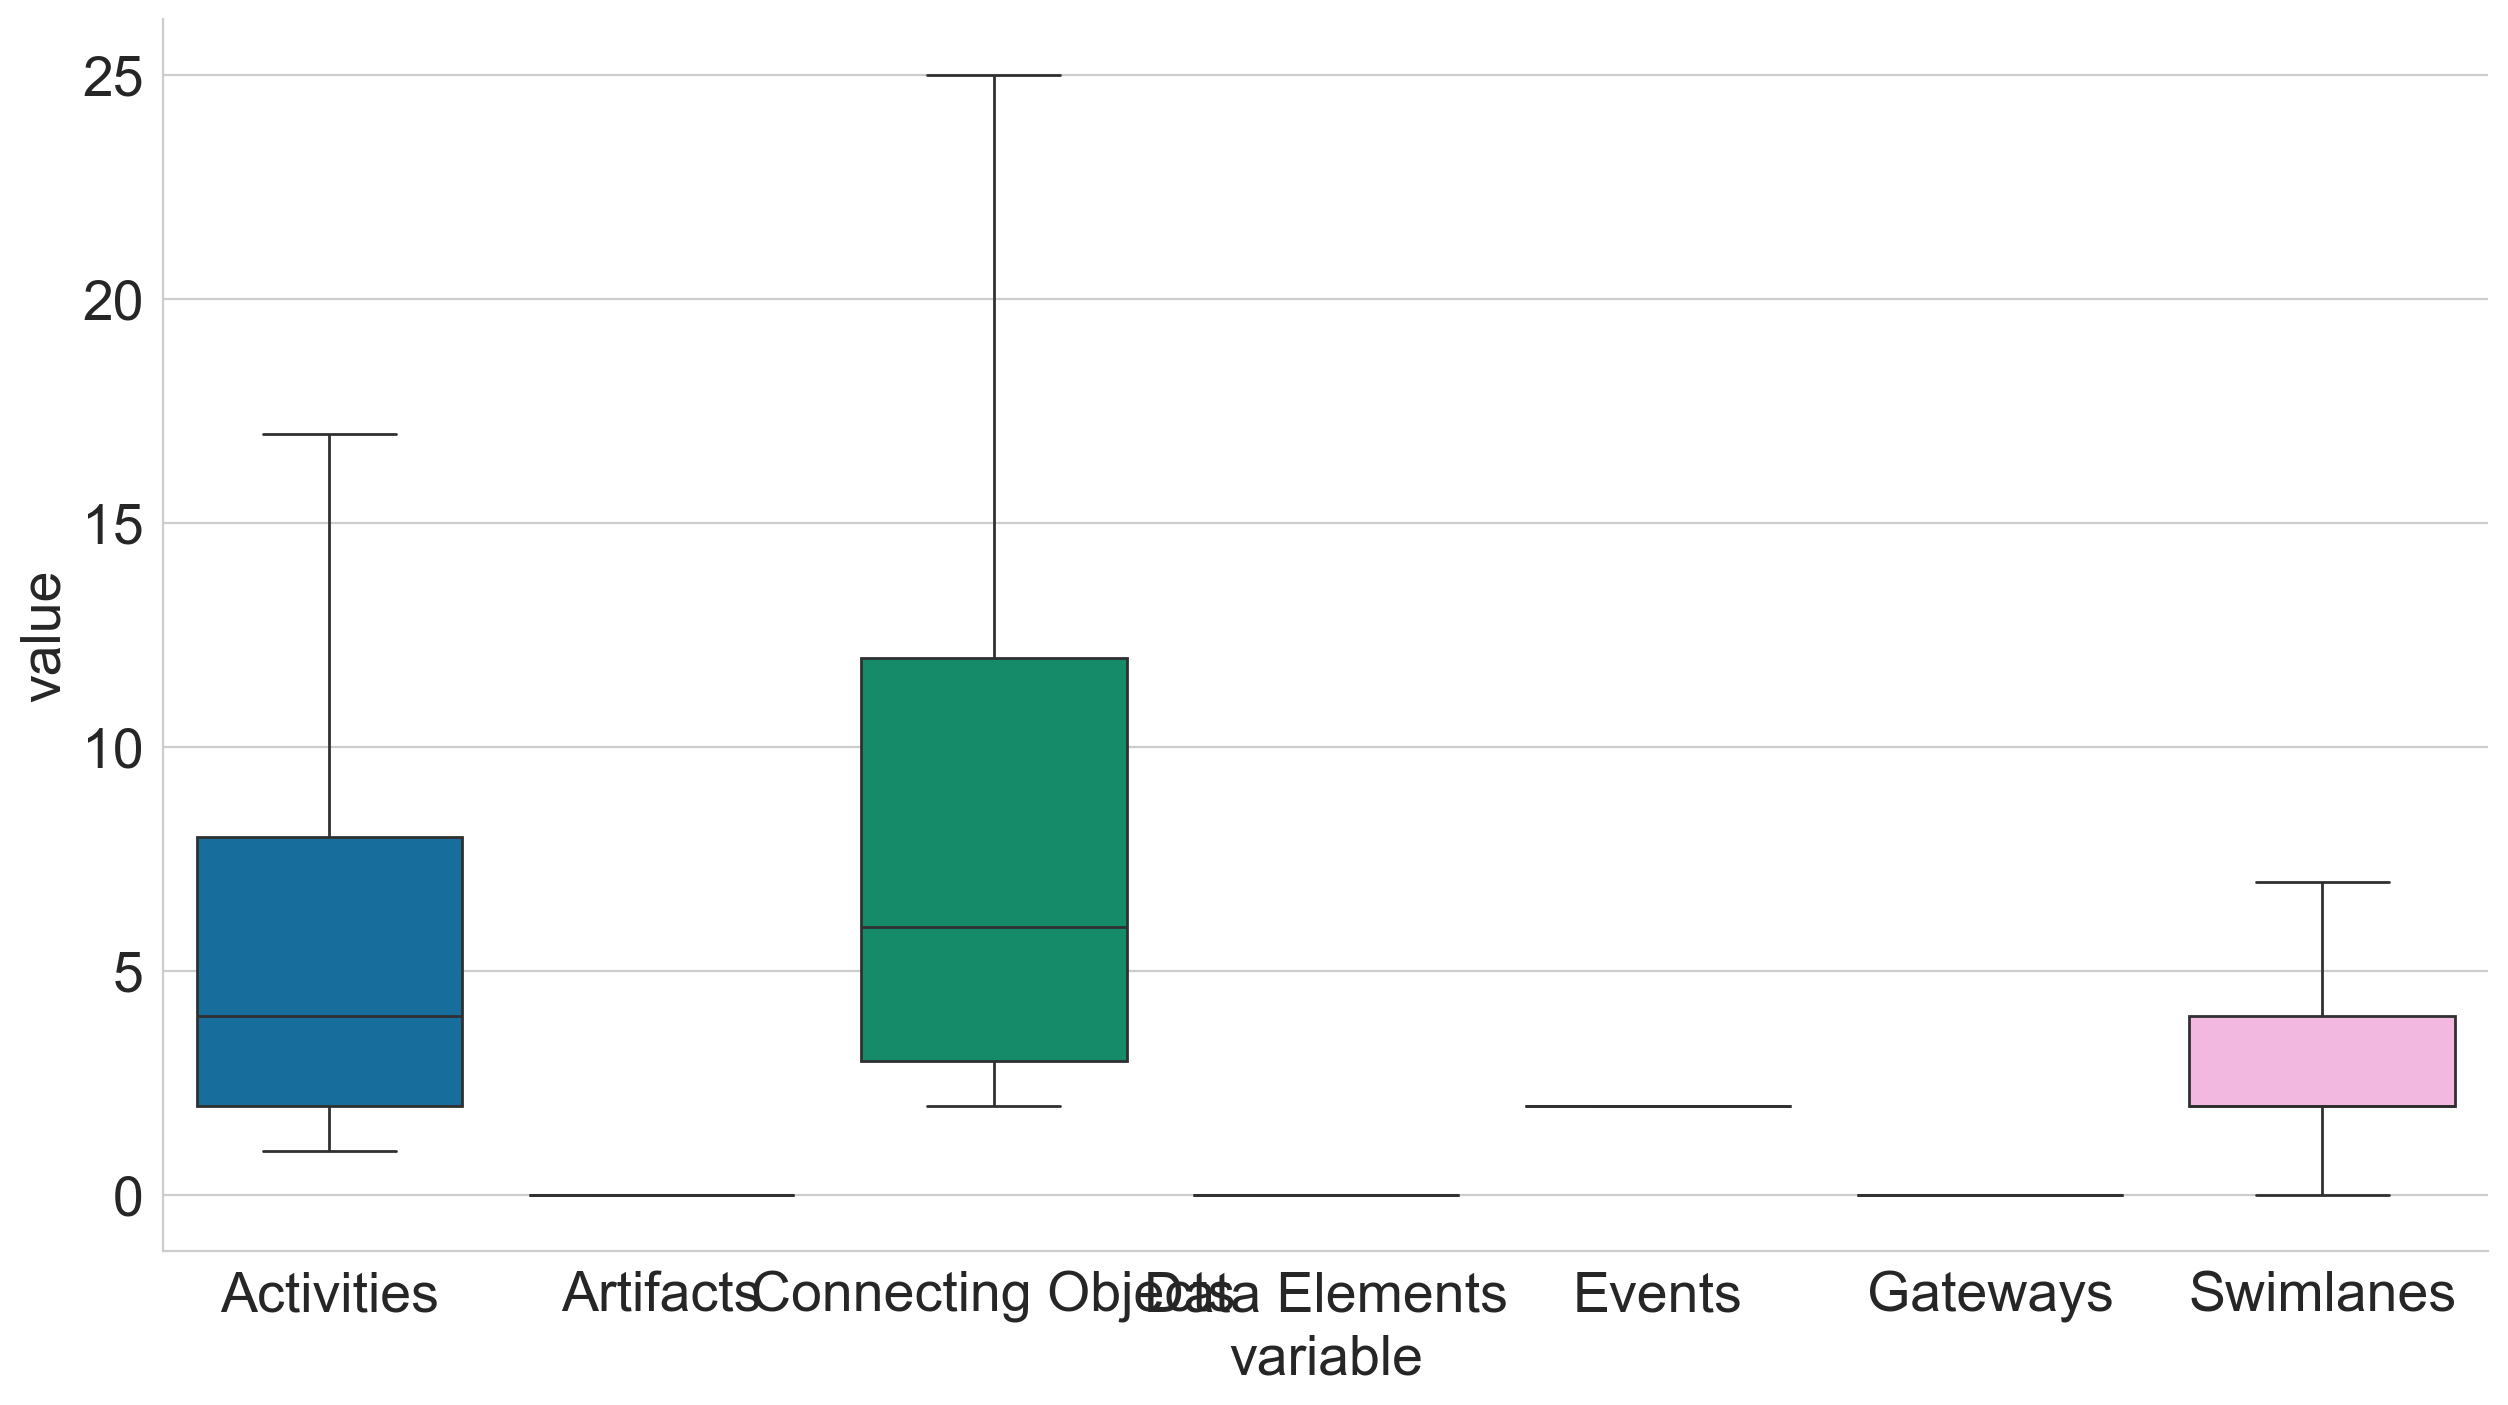

In [73]:
plt.figure(figsize=(15,8))
df_low_level["id"] = df_low_level.index
df_low_level_long = pd.melt(df_low_level, id_vars='id', value_vars=['Activities', 'Artifacts', 'Connecting Objects', 'Data Elements', 'Events', 'Gateways', 'Swimlanes'])
ax=sns.boxplot(x="variable", y="value", hue="variable", legend=False, data=df_low_level_long,showfliers=False,palette=sns.color_palette("colorblind", n_colors=7))
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
sns.despine()

Now, let's also have a look at a higher level aggregation (categories: nodes and edges).

In [74]:
df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()
df_high_level.rename(columns={"edge": "No. of Edges", "node": "No. of Nodes"},inplace=True)
df_high_level.describe().transpose()

count       mean        std  min  25%  50%   75%    max
No. of Edges  4232.0  10.625473  13.567738  2.0  3.0  6.0  12.0  155.0
No. of Nodes  4232.0  14.458648  13.607011  4.0  6.0  9.0  17.0  138.0

In [75]:
df_high_level.head()

No. of Edges  No. of Nodes
0            55            65
1            18            27
2             3             6
3            13            21
4             5             9

The number of nodes and edges is naturally highly correlated:

<Figure size 500x500 with 0 Axes>

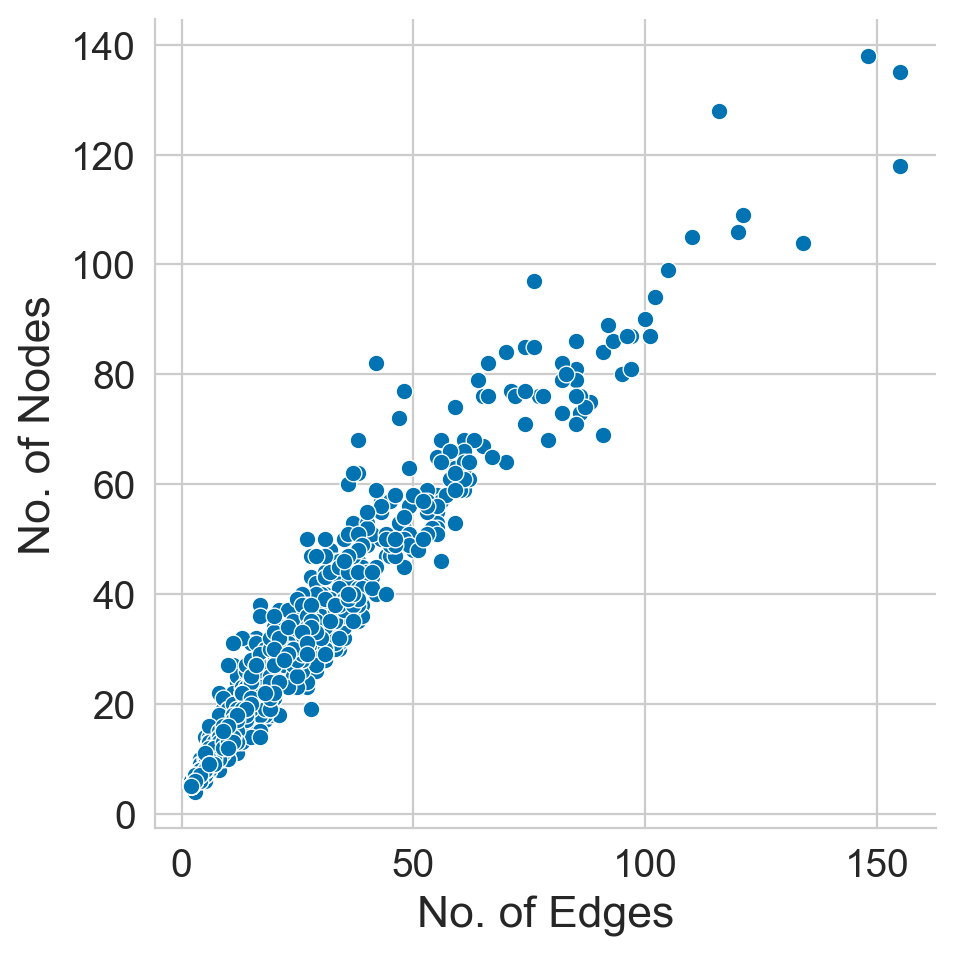

In [76]:
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 14,'axes.labelsize': 16})
ax = sns.relplot(data=df_high_level.astype(float), x = "No. of Edges", y = "No. of Nodes",color=sns.color_palette("colorblind",as_cmap=True)[0])
sns.despine()
#plt.savefig(constants.FIGURES_ROOT / 'correl_plot.png',transparent=True,bbox_inches = 'tight',dpi=300)
plt.savefig(constants.FIGURES_ROOT / 'correl_plot.pdf',transparent=True,bbox_inches = 'tight')

# Process names 

Let's now have a look at the process names.

A function for cleaning the names or labels (if required for the use case):

In [77]:
def clean(label):
    # handle some special cases
    label = label.replace("\n", " ").replace("\r", "")
    label = label.replace("(s)", "s")
    # turn any non alphanumeric characters into whitespace
    # label = re.sub("[^A-Za-z]"," ",label)
    # delete unnecessary whitespaces
    label = label.strip()
    label = re.sub("\s{1,}"," ",label)
    # make all lower case
    label = label.lower()
    return label

def alphanumeric(label):
    return re.sub("[^A-Za-z]"," ",label)

In [78]:
cnts_names = dict(Counter(df_meta['name'].values))
#cnts_names = dict(Counter(df_meta['name'].apply(lambda x: clean(str(x))).values))
cnts_names = pd.DataFrame.from_dict(cnts_names.items())
cnts_names.columns = ['name', 'occurrences']
cnts_names = cnts_names.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_names.head(10)

name  occurrences
0   DPS Deliver Products &amp; Services            8
1           DPS-90-10 Billing Documents            7
2            DPS-70-10 Sales Management            7
3    J60 - 02 - Preparation of Payments            6
4                  MLG Manage Logistics            6
5         DPS-80-10 Delivery Management            6
6  PMS Procure Materials &amp; Services            5
7  PMS-20-30 Receive Goods and Services            5
8    PMS-20-20 Order Goods and Services            5
9                 MFS Manage Financials            5

The number of distinct process names:

In [79]:
len(cnts_names)

6716

We use Signavio's color palette for the word cloud.

In [80]:
import random
colors = constants.COLORS_SIGNAVIO_HSL 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

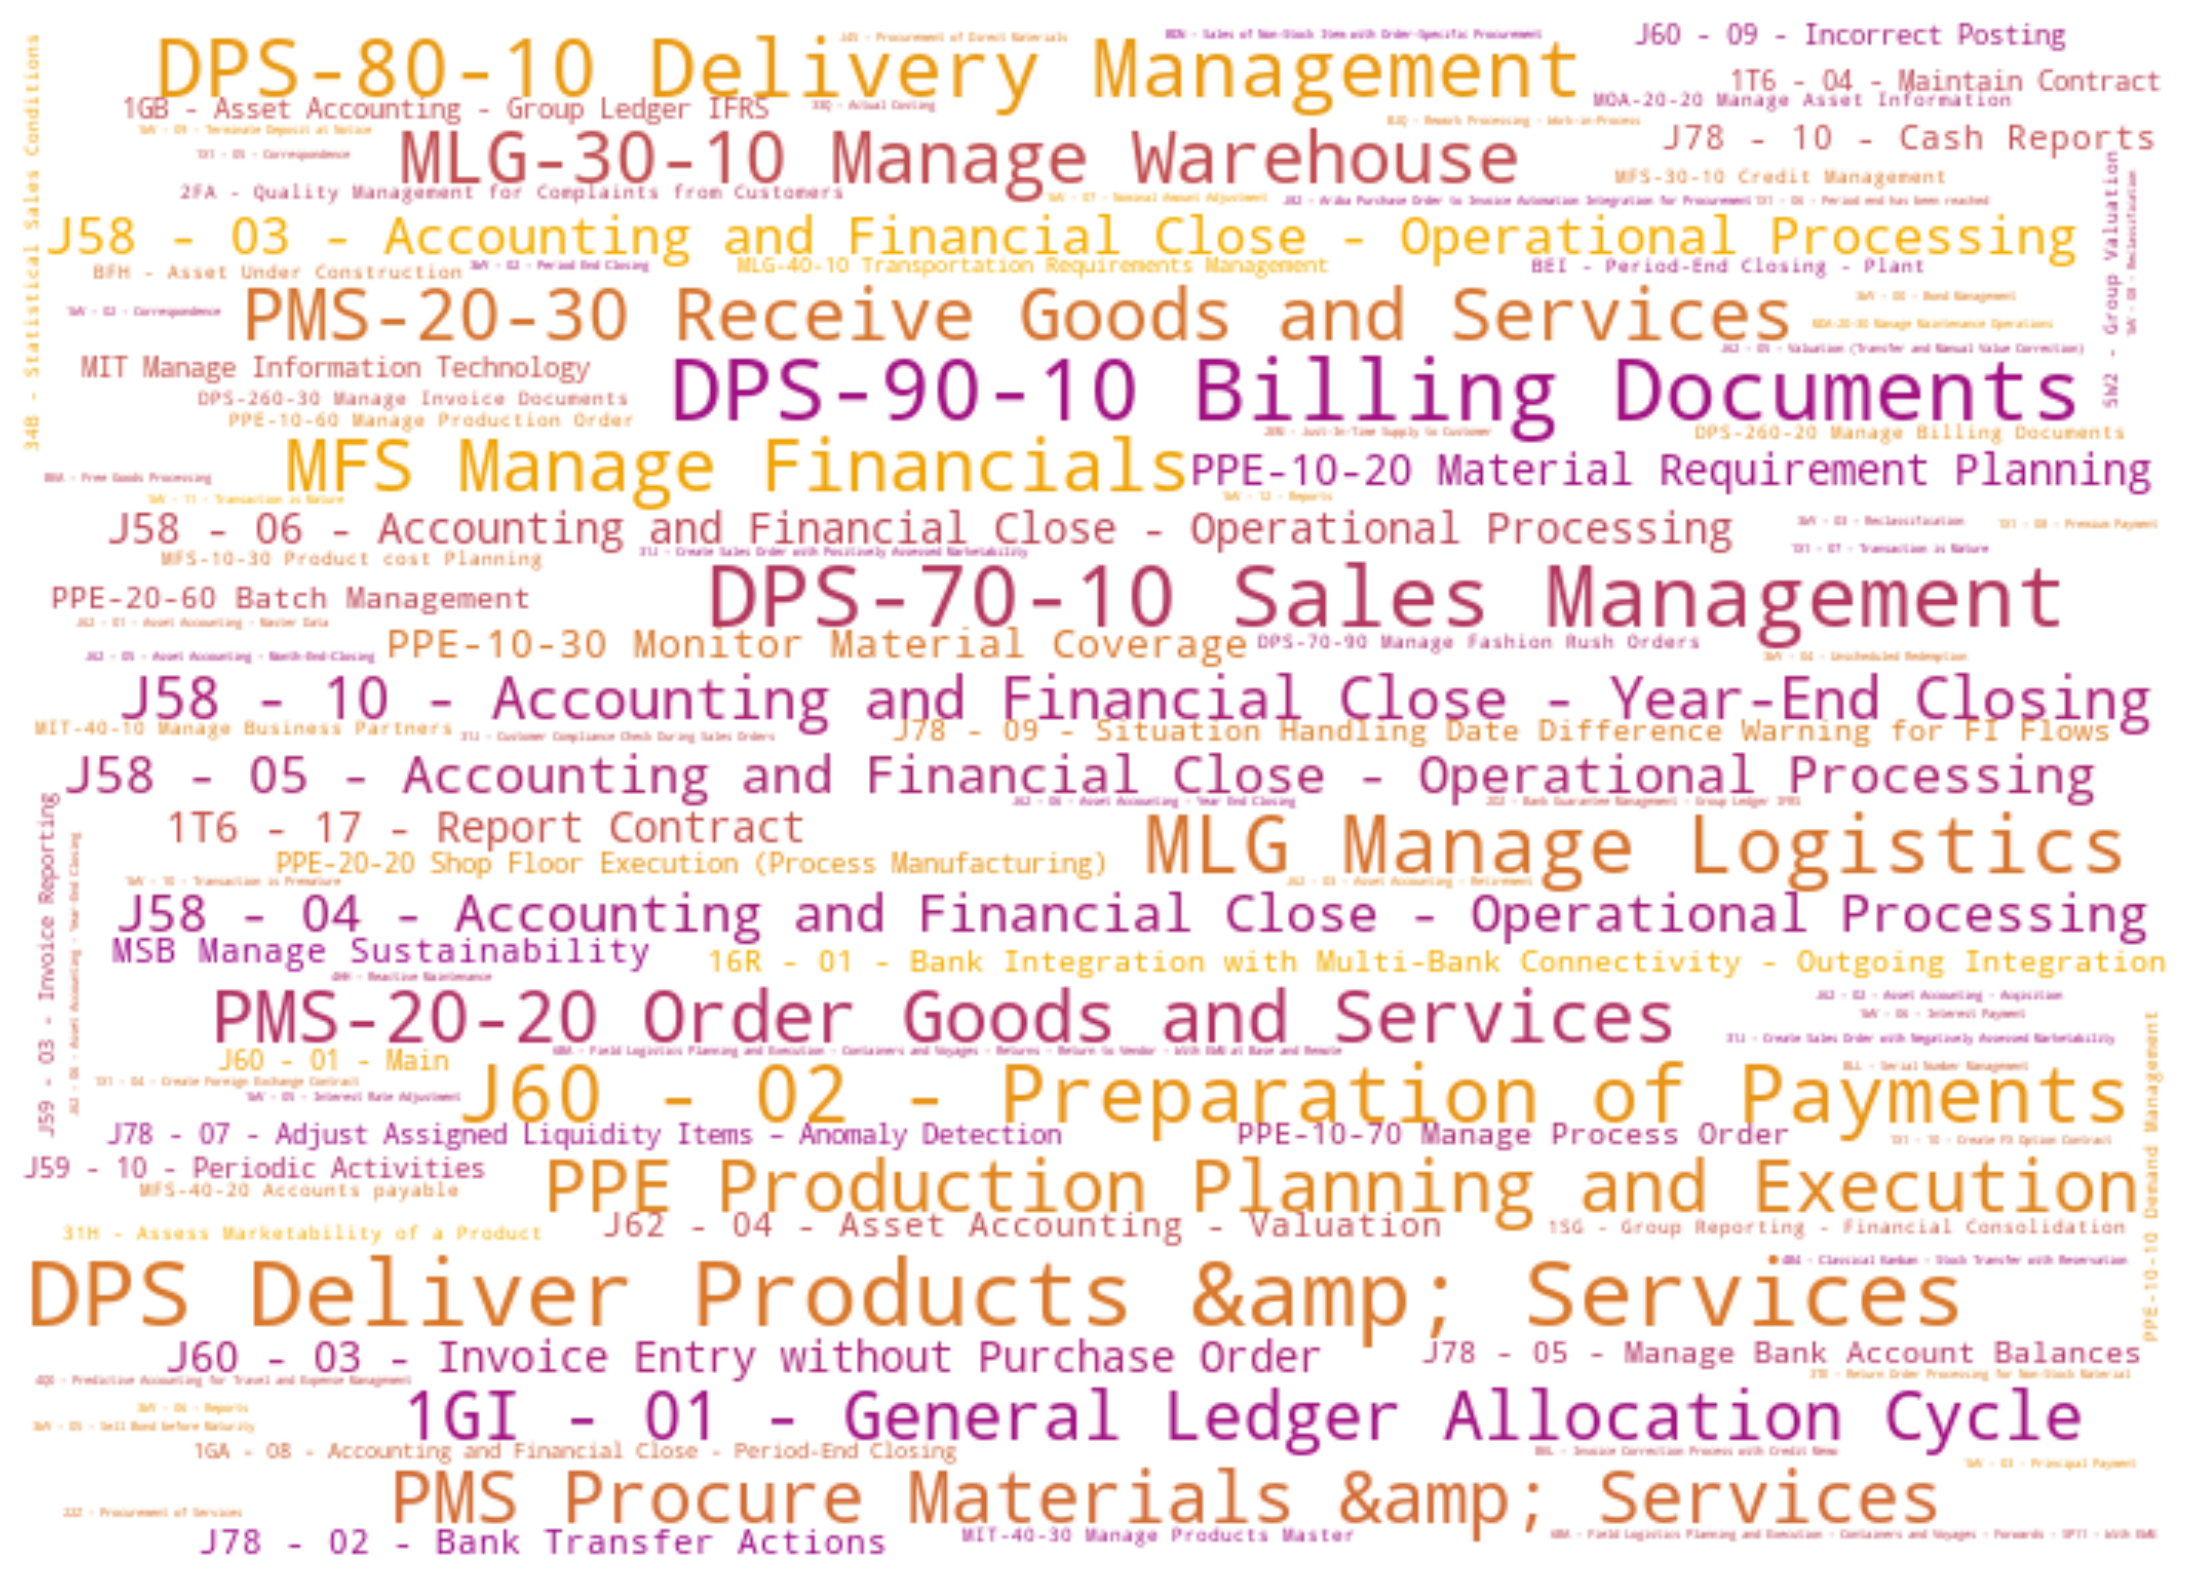

In [81]:
wordcloud_dict_names = dict(zip(cnts_names.name, cnts_names.occurrences))
wordcloud = WordCloud(min_word_length=1,background_color='white',width=700, height=500)
wordcloud = wordcloud.generate_from_frequencies(wordcloud_dict_names)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_process_names.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

It seems like the word cloud is dominated by the process names of the examples processes that are added to each newly created workspace.

# Labels

Let's also investigate element labels.

In [82]:
# cnts_labels = dict(Counter(df_bpmn['label'].apply(lambda x: clean(str(x))).values))
cnts_labels = dict(Counter(df_bpmn['label'].values))
cnts_labels = pd.DataFrame.from_dict(cnts_labels.items())
cnts_labels.columns = ['label', 'occurrences']
cnts_labels = cnts_labels.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_labels = cnts_labels[~cnts_labels.label.isin([None,""])]
cnts_labels.reset_index(drop=True, inplace=True)
cnts_labels.head(10)

label  occurrences
0                      End Event          846
1                    Start Event          618
2                            Yes          354
3                             No          347
4                      Purchaser          335
5                Warehouse Clerk          318
6            Shipping Specialist          271
7  Internal Sales Representative          269
8           SAP Business Network          266
9                   Customer ERP          250

The number of distinct element labels:

In [83]:
len(cnts_labels)

18110

2.820.531 labels are used for the 28.293.762 elements in the BPMN models:

In [84]:
len(df_bpmn)

106156

10 % of the unique labels make up for more than 74.0 % of the element labels ...

In [85]:
sum(cnts_labels.occurrences[:int(len(cnts_labels)*0.1)])/sum(cnts_labels.occurrences)

0.530019120458891

... while 64.9 % of the labels are used for only one element.

In [86]:
len(cnts_labels[cnts_labels.occurrences==1])/len(cnts_labels)

0.5287134180011044

In [87]:
len(cnts_labels[cnts_labels.occurrences==1])

9575

Let's visualize the distribution of the label usage frequency in BPMN 2.0 models.

In [88]:
bins = cnts_labels
bins.head()

label  occurrences
0    End Event          846
1  Start Event          618
2          Yes          354
3           No          347
4    Purchaser          335

We sort the labels based on their absolute usage frequency in descending order and group them in bins of size 10,000 to visualize the unevenness of the distribution.

In [89]:
N = 10000
bins = bins.groupby(bins.index // N).sum(numeric_only=True)

In [90]:
import math

bins["bins of labels"] = [N*i for i in range(1,math.ceil(len(cnts_labels)/N)+1)]
bins.head()

occurrences  bins of labels
0        46805           10000
1         8110           20000

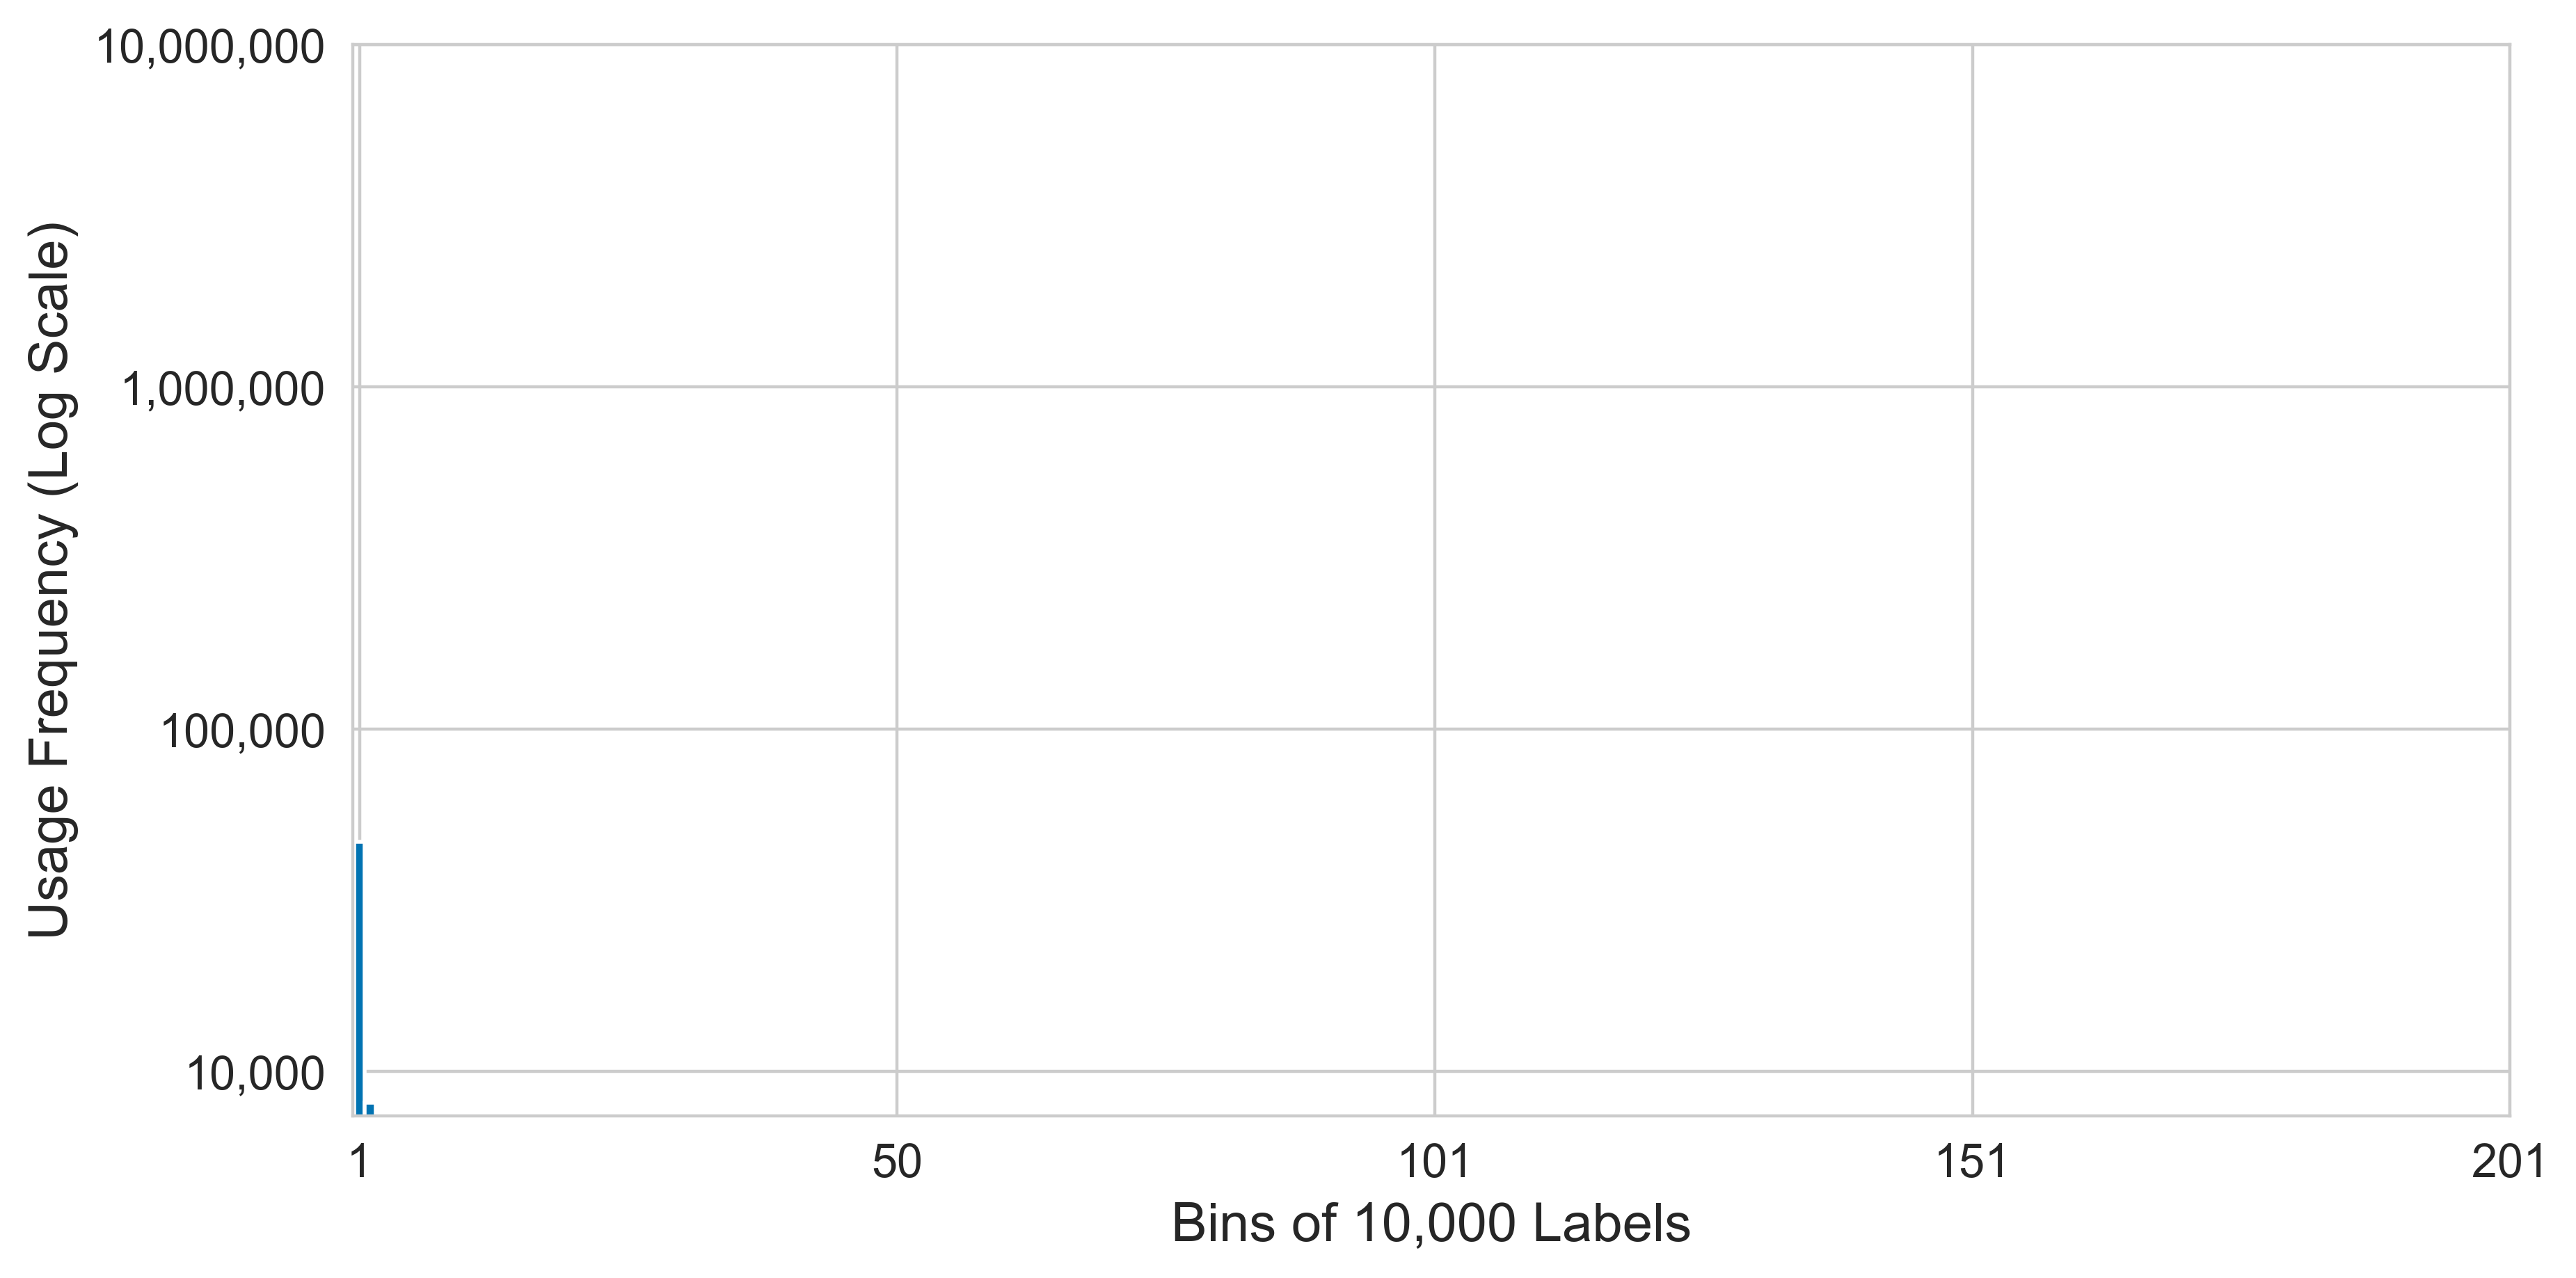

In [91]:
nb_of_bins = len(bins)
plt.figure(figsize=(10,5),dpi=200)
plt.rcParams.update({'font.size': 12,'axes.labelsize': 14})
ax=plt.bar([i for i in range(0,nb_of_bins)],height=list(bins["occurrences"]),width=1,color=sns.color_palette("colorblind",as_cmap=True)[0])
plt.yscale('log')
plt.xticks([0,50,100,150,200], ["1","50","101","151","201"])
plt.yticks(np.array([1.e+04, 1.e+05, 1.e+06, 1.e+07]),["10,000","100,000","1,000,000","10,000,000"])
plt.xlabel("Bins of 10,000 Labels")
plt.ylabel("Usage Frequency (Log Scale)")
plt.savefig(constants.FIGURES_ROOT / 'labels_usage.pdf',transparent=True,bbox_inches = 'tight')

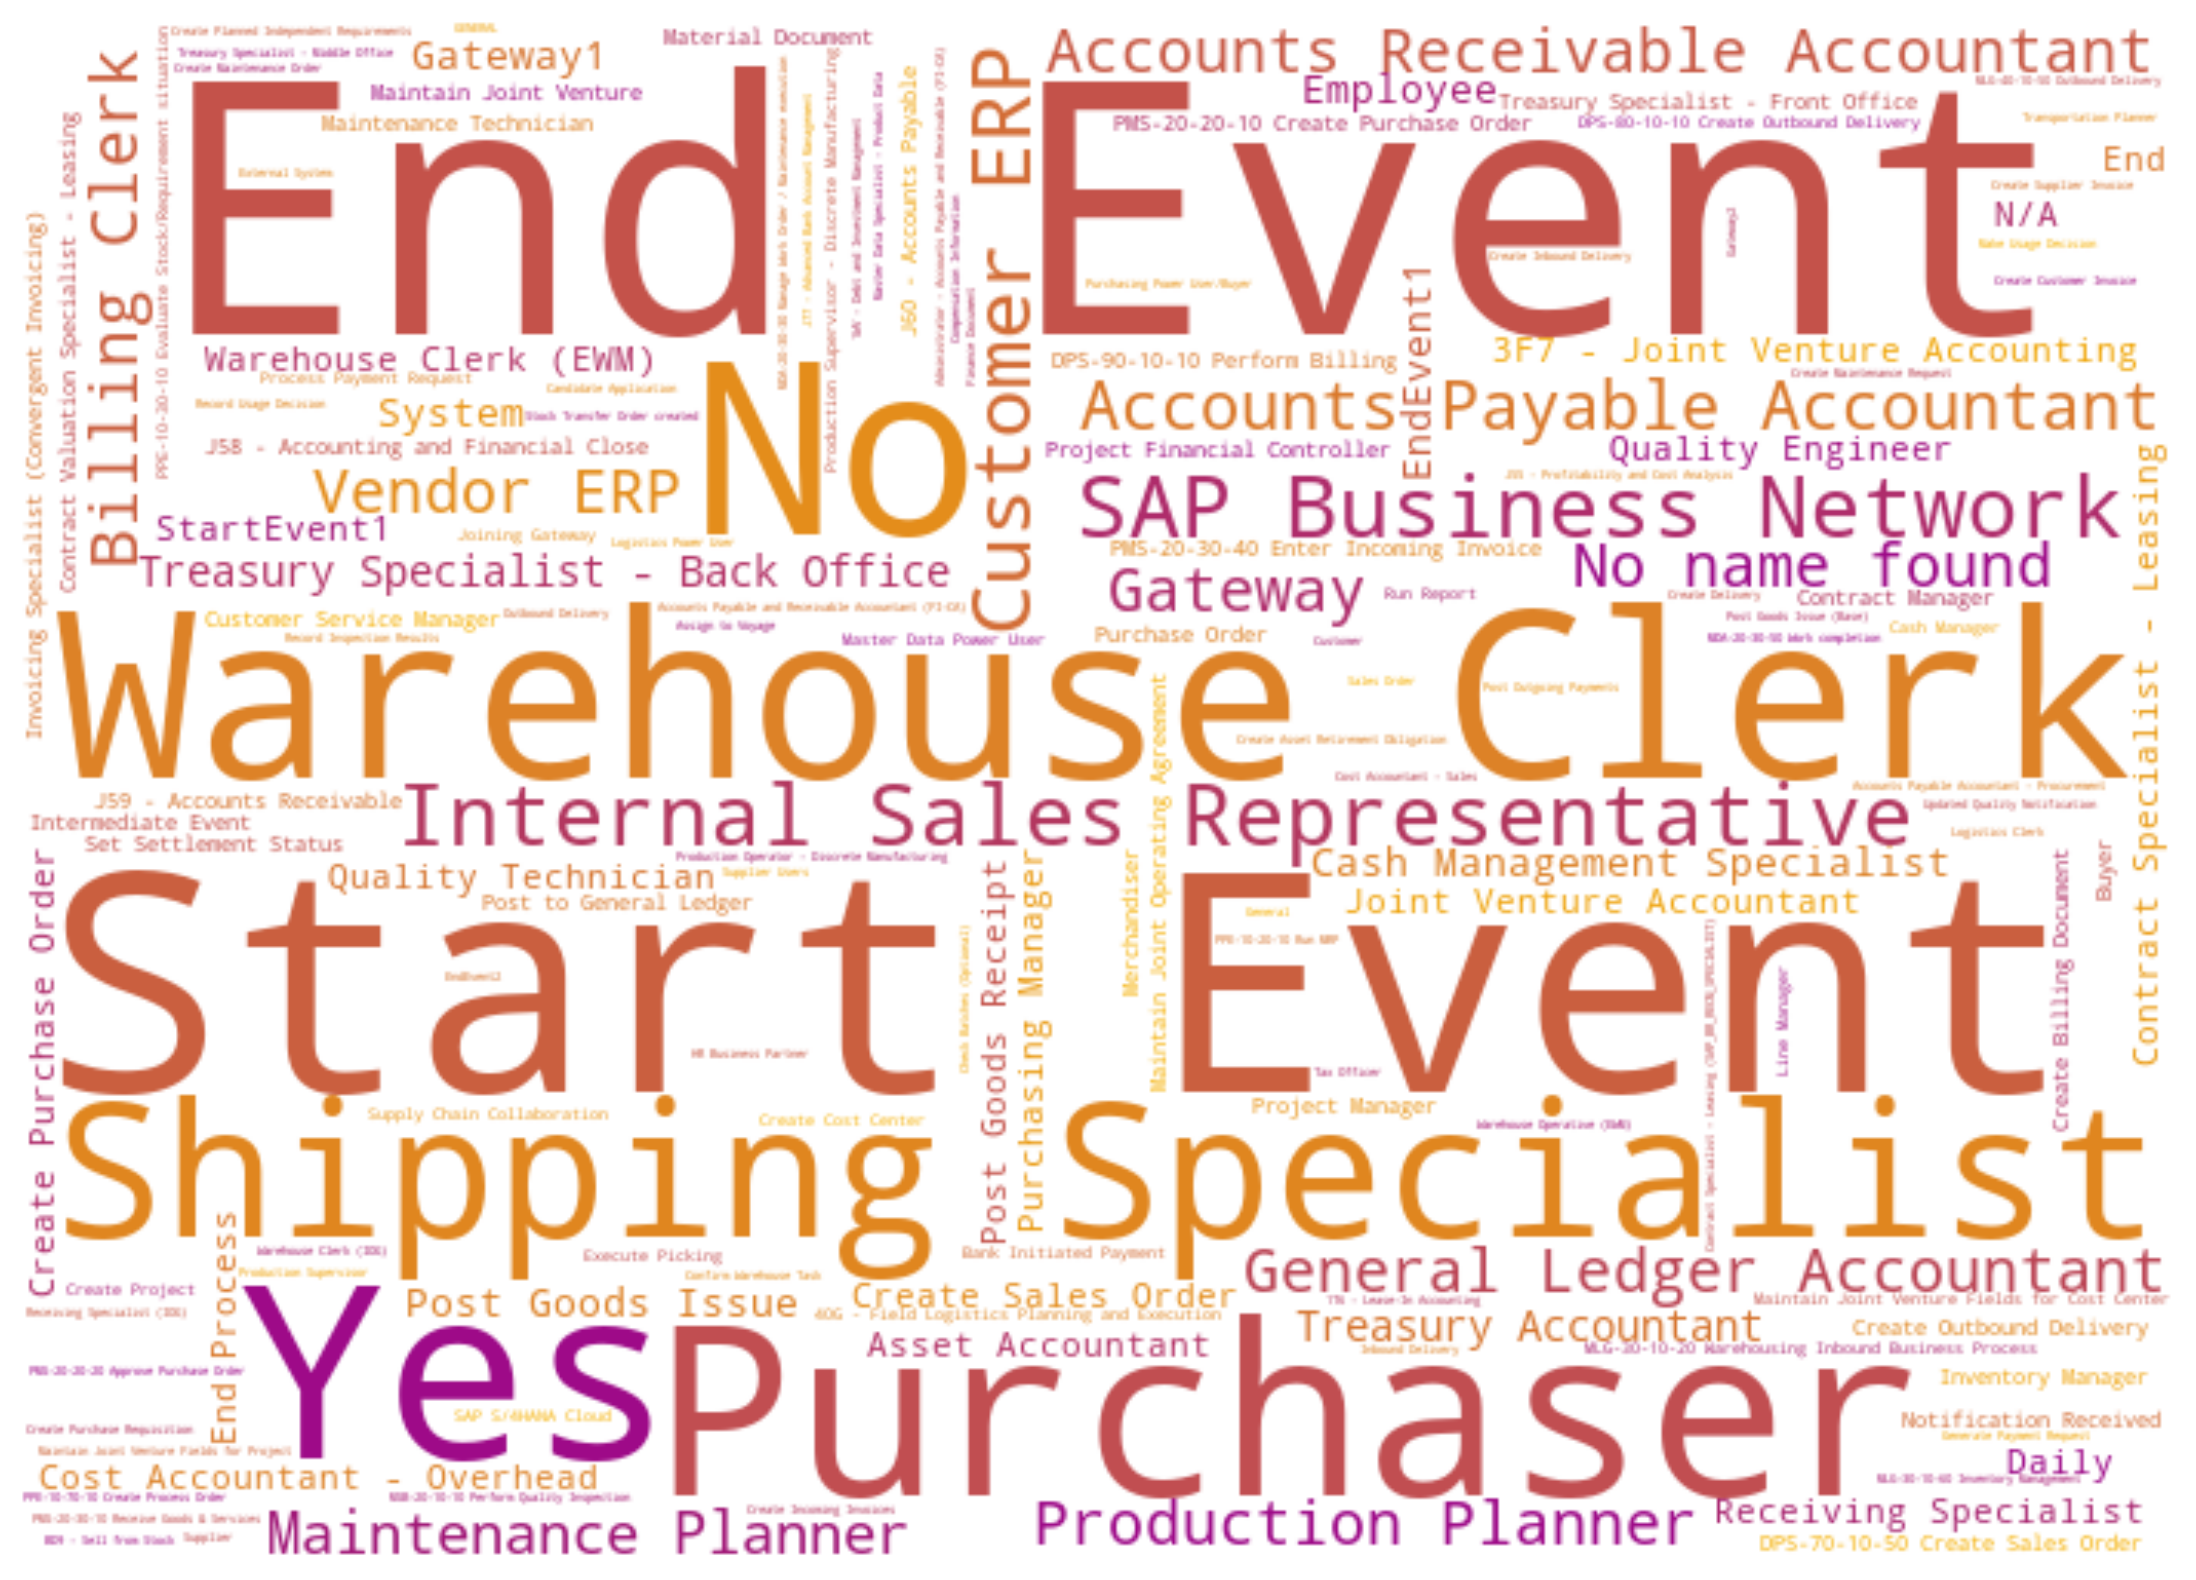

In [92]:
wordcloud_dict_labels = dict(zip(cnts_labels.label, cnts_labels.occurrences))
wordcloud_dict_labels = {k: v for k, v in wordcloud_dict_labels.items() if '\n' not in k}
wordcloud = WordCloud(min_word_length=2,background_color='white',width=700, height=500)
wordcloud.generate_from_frequencies(wordcloud_dict_labels)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_labels.pdf',transparent=True,bbox_inches = 'tight')
plt.show()